In [ ]:
# Install required packages
!pip install earthengine-api
!pip install geemap
!pip install folium
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00


In [ ]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
project_id = 'ee-cuneerajjaiswal'
# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project = project_id)

In [ ]:
# Create a new map to draw area of interest
Map = geemap.Map()
Map.add_basemap('SATELLITE')

# Add drawing tools to the map
Map.draw_features

print("Instructions:")
print("1. Use the drawing tools in the upper left corner of the map")
print("2. Click the polygon tool (rectangle or polygon)")
print("3. Draw your area of interest")
print("4. After drawing, the coordinates will be stored")

Map

Instructions:
1. Use the drawing tools in the upper left corner of the map
2. Click the polygon tool (rectangle or polygon)
3. Draw your area of interest
4. After drawing, the coordinates will be stored


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Get the last drawn feature and convert to ROI
aoi = Map.draw_last_feature
if aoi:
    print("Area of interest successfully captured!")
    # Convert to Earth Engine geometry
    roi = ee.Geometry(aoi.geometry())
    print("ROI successfully created!")
else:
    print("Please draw an area first!")

Area of interest successfully captured!
ROI successfully created!


In [ ]:
# Define time period
start_date = '2023-01-01'
end_date = '2023-12-31'

# Get Sentinel-2 imagery
s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                .filterBounds(roi)
                .filterDate(start_date, end_date)
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

# Print number of images
print(f"Number of images found: {s2_collection.size().getInfo()}")

# Get the first image
first_image = ee.Image(s2_collection.first())

# Create visualization parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

# Create new map
new_map = geemap.Map()

# Add layers
new_map.centerObject(roi, 10)
new_map.addLayer(first_image, vis_params, 'Sentinel-2 Image')
new_map.addLayer(roi, {'color': 'red'}, 'Study Area')

# Display map
new_map

Number of images found: 75


Map(center=[30.886487455173757, 75.96531000000114], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Function to calculate NDVI
def calculate_ndvi(image):
    # Select NIR (B8) and RED (B4) bands
    nir = image.select('B8')
    red = image.select('B4')

    # Calculate NDVI
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    return ndvi

# Get a cloud-free image composite
composite = s2_collection.median().clip(roi)

# Calculate NDVI
ndvi = calculate_ndvi(composite)

# Set visualization parameters for NDVI
ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['#ff0000', '#ffff00', '#00ff00']  # Red to Yellow to Green
}

# Create a new map for NDVI visualization
ndvi_map = geemap.Map()
ndvi_map.centerObject(roi, 10)

# Add NDVI layer
ndvi_map.addLayer(ndvi.clip(roi), ndvi_viz, 'NDVI')

# Add legend with correct format
legend_keys = ['Poor Vegetation (-1 to 0)', 'Moderate Vegetation (0 to 0.5)', 'Healthy Vegetation (0.5 to 1)']
legend_colors = ['#ff0000', '#ffff00', '#00ff00']

ndvi_map.add_legend(
    title='NDVI Values',
    colors=legend_colors,
    keys=legend_keys
)

# Display the map
ndvi_map

Map(center=[30.886487455173757, 75.96531000000114], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Calculate NDVI statistics for the region
stats = ndvi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ).combine(
        reducer2=ee.Reducer.minMax(),
        sharedInputs=True
    ),
    geometry=roi,
    scale=10,
    maxPixels=2e9
)

# Print statistics
print("\nNDVI Statistics for your region:")
print(f"Mean NDVI: {stats.get('NDVI_mean').getInfo():.3f}")
print(f"Standard Deviation: {stats.get('NDVI_stdDev').getInfo():.3f}")
print(f"Minimum NDVI: {stats.get('NDVI_min').getInfo():.3f}")
print(f"Maximum NDVI: {stats.get('NDVI_max').getInfo():.3f}")


NDVI Statistics for your region:
Mean NDVI: 0.214
Standard Deviation: 0.111
Minimum NDVI: -0.048
Maximum NDVI: 0.546


In [ ]:
s2_collection.size().getInfo()

75

In [ ]:
# Define export task
export_task = ee.batch.Export.image.toDrive(
    image=ndvi,
    description='NDVI_Export',
    folder='NDVI_Data',  # Change to your Google Drive folder
    fileNamePrefix='NDVI_Map',
    region=roi,
    scale=10,
    maxPixels=2e9
)

# Start export task
export_task.start()
print("Exporting NDVI as GeoTIFF... Check Google Drive for the file.")


Exporting NDVI as GeoTIFF... Check Google Drive for the file.


In [ ]:
# Reduce NDVI values to a CSV format
ndvi_stats = ndvi.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=roi,
    scale=10,
    maxPixels=2e9
)

# Convert to Pandas DataFrame
ndvi_values = ndvi_stats.get('NDVI').getInfo()
ndvi_df = pd.DataFrame({'NDVI': ndvi_values})

# Save as CSV
ndvi_df.to_csv('ndvi_values.csv', index=False)
print("NDVI values saved as CSV. Download it from Google Colab Files.")


NDVI values saved as CSV. Download it from Google Colab Files.


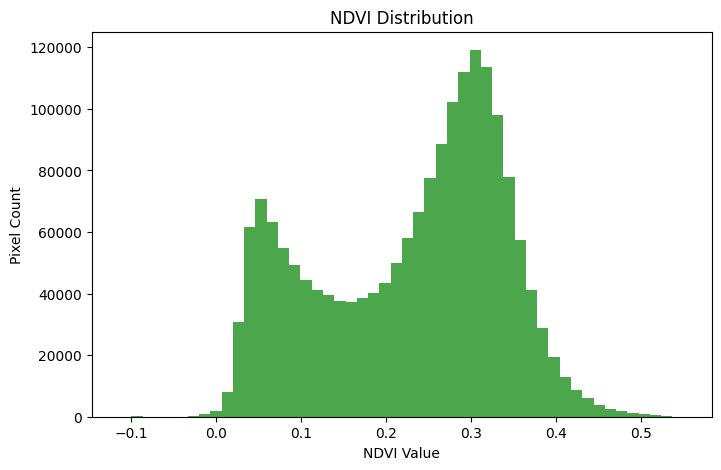

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(ndvi_values, bins=50, color='green', alpha=0.7)
plt.xlabel('NDVI Value')
plt.ylabel('Pixel Count')
plt.title('NDVI Distribution')
plt.show()


In [ ]:
# Dictionary to handle month-end dates correctly
month_end_days = {
    1: 31,  2: 28,  3: 31,  4: 30,  5: 31,  6: 30,
    7: 31,  8: 31,  9: 30, 10: 31, 11: 30, 12: 31
}

# Function to calculate NDVI for each month
def get_monthly_ndvi(year, month):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-{month_end_days[month]}'

    monthly_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                          .filterBounds(roi)
                          .filterDate(start_date, end_date)
                          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    # Get median image for the month
    monthly_composite = monthly_collection.median()

    # Calculate NDVI
    ndvi = calculate_ndvi(monthly_composite)

    return ndvi

# Generate NDVI for each month in 2023
monthly_ndvi_images = {}
for month in range(1, 13):
    monthly_ndvi_images[month] = get_monthly_ndvi(2023, month)

print("Monthly NDVI images generated successfully!")


Monthly NDVI images generated successfully!


In [ ]:
# Define seasonal ranges (adjust based on the region)
seasons = {
    'Winter': [12, 1, 2],
    'Summer': [3, 4, 5],
    'Monsoon': [6, 7, 8],
    'Post-Monsoon': [9, 10, 11]
}

# Compute NDVI for each season
seasonal_ndvi = {}
for season, months in seasons.items():
    season_collection = ee.ImageCollection([
        monthly_ndvi_images[month] for month in months
    ])

    # Take the median NDVI for the season
    seasonal_ndvi[season] = season_collection.median()

print("Seasonal NDVI images generated successfully!")


Seasonal NDVI images generated successfully!


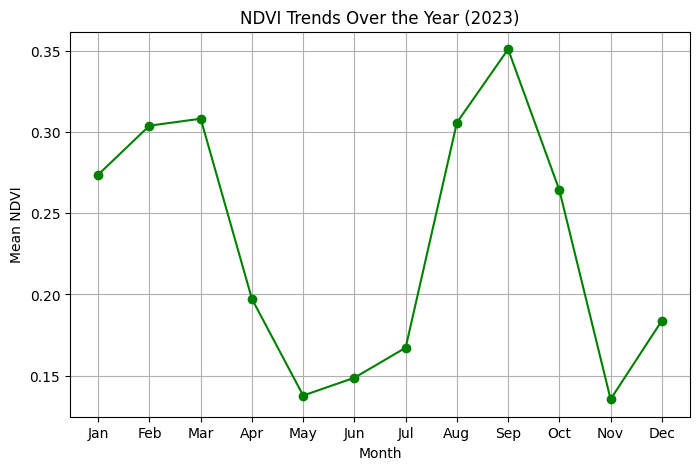

In [ ]:
# Extract mean NDVI values for each month
monthly_means = []
for month in range(1, 13):
    stats = monthly_ndvi_images[month].reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=2e9
    )
    monthly_means.append(stats.get('NDVI').getInfo())

# Plot NDVI trends
plt.figure(figsize=(8, 5))
plt.plot(range(1, 13), monthly_means, marker='o', color='green', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Mean NDVI')
plt.title('NDVI Trends Over the Year (2023)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


In [ ]:
for season, ndvi_image in seasonal_ndvi.items():
    task = ee.batch.Export.image.toDrive(
        image=ndvi_image,
        description=f'NDVI_{season}',
        folder='NDVI_Seasons',
        fileNamePrefix=f'NDVI_{season}',
        region=roi,
        scale=10,
        maxPixels=2e9
    )
    task.start()
    print(f"Exporting {season} NDVI map to Google Drive...")


Exporting Winter NDVI map to Google Drive...
Exporting Summer NDVI map to Google Drive...
Exporting Monsoon NDVI map to Google Drive...
Exporting Post-Monsoon NDVI map to Google Drive...


In [ ]:
# Define classification thresholds
ndvi_classified = (ndvi
                   .expression(
                       "(b(0) <= 0) ? 0 : "  # Water & barren land
                       "(b(0) > 0 && b(0) <= 0.2) ? 1 : "  # Bare soil, sparse vegetation
                       "(b(0) > 0.2 && b(0) <= 0.5) ? 2 : "  # Moderate vegetation
                       "3",  # Dense vegetation
                       {'b(0)': ndvi}
                   ).rename('NDVI_Classified'))

# Define classification visualization
ndvi_class_viz = {
    'min': 0,
    'max': 3,
    'palette': ['#808080', '#ffff00', '#FFA500', '#008000']  # Gray, Yellow, Orange, Green
}

# Create a new map for classified NDVI
ndvi_class_map = geemap.Map()
ndvi_class_map.centerObject(roi, 10)

# Add NDVI classification layer
ndvi_class_map.addLayer(ndvi_classified.clip(roi), ndvi_class_viz, 'NDVI Classification')

# Add legend
legend_keys = ['Water/Barren Land', 'Bare Soil/Sparse Vegetation', 'Moderate Vegetation', 'Dense Vegetation']
legend_colors = ['#808080', '#ffff00', '#FFA500', '#008000']

ndvi_class_map.add_legend(
    title='NDVI Classification',
    colors=legend_colors,
    keys=legend_keys
)

# Display map
ndvi_class_map


Map(center=[30.871166053397097, 75.98118049999965], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Export the classified NDVI image to Google Drive
export_task = ee.batch.Export.image.toDrive(
    image=ndvi_classified,
    description='NDVI_Classified_Image',
    folder='GEE_Exports',
    fileNamePrefix='NDVI_Classification',
    region=roi,
    scale=10,
    maxPixels=1e9
)

export_task.start()
print("Export task started! Check Google Drive for the file.")


Export task started! Check Google Drive for the file.


In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.9 MB/s eta 0:00:00


In [ ]:
import rasterio
import json
import numpy as np

# Define paths to NDVI TIFF files
ndvi_files = {
    "Post-Monsoon": "/content/drive/MyDrive/NDVI_Research/NDVI_Seasons/NDVI_Post-Monsoon.tif",
    "Monsoon": "/content/drive/MyDrive/NDVI_Research/NDVI_Seasons/NDVI_Monsoon.tif",
    "Summer": "/content/drive/MyDrive/NDVI_Research/NDVI_Seasons/NDVI_Summer.tif",
    "Winter": "/content/drive/MyDrive/NDVI_Research/NDVI_Seasons/NDVI_Winter.tif",
    "Current NDVI": "/content/drive/MyDrive/NDVI_Research/NDVI_Data/NDVI_Map.tif"
}

# Function to extract summary statistics from NDVI data
def get_ndvi_summary(file_path):
    with rasterio.open(file_path) as dataset:
        ndvi_array = dataset.read(1)  # Read the first band
        ndvi_array = ndvi_array[ndvi_array > -1]  # Remove invalid values

        if ndvi_array.size == 0:
            return {"mean": None, "min": None, "max": None, "std_dev": None}

        return {
            "mean": round(np.mean(ndvi_array), 4),
            "min": round(np.min(ndvi_array), 4),
            "max": round(np.max(ndvi_array), 4),
            "std_dev": round(np.std(ndvi_array), 4)
        }

# Generate summary for each season
ndvi_summary = {season: get_ndvi_summary(file_path) for season, file_path in ndvi_files.items()}

# Save as JSON file
output_json_path = "ndvi_summary.json"
with open(output_json_path, "w") as json_file:
    json.dump(ndvi_summary, json_file, indent=4)

print(f"NDVI summary saved successfully in {output_json_path}")


NDVI summary saved successfully in ndvi_summary.json


In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import requests
import json

# Groq API Key (Replace with your actual key)
GROQ_API_KEY = "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"
GROQ_ENDPOINT = "https://api.groq.com/v1/chat/completions"

# Load NDVI summary data
ndvi_json_path = "ndvi_summary.json"
try:
    with open(ndvi_json_path, "r") as file:
        ndvi_data = json.load(file)
except FileNotFoundError:
    ndvi_data = {}

# Function to query LLaMA via Groq API
def get_ndvi_insights(ndvi_data, user_query):
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }

    prompt = f"NDVI Data Summary: {json.dumps(ndvi_data, indent=2)}\nUser Query: {user_query}\nProvide insights based on NDVI trends."

    payload = {
        "model": "llama-3.3-70b-versatile",
        "messages": [{"role": "system", "content": "You are an NDVI analysis assistant."},
                     {"role": "user", "content": prompt}],
        "temperature": 0.7
    }

    response = requests.post(GROQ_ENDPOINT, headers=headers, json=payload)
    return response.json().get("choices", [{}])[0].get("message", {}).get("content", "No response.")

# Streamlit UI
st.set_page_config(page_title="NDVI Chatbot", layout="wide")

st.sidebar.title("Settings")
st.sidebar.write("This chatbot provides insights based on NDVI data.")

st.title("🌱 NDVI Chatbot - Land Vegetation Insights")
st.markdown("#### Ask questions about vegetation trends, greenery, and government measures.")

# Display loaded NDVI data
st.write("### 📊 Latest NDVI Summary")
st.json(ndvi_data)

# User input
user_query = st.text_area("💬 Ask your question about vegetation trends:")

if st.button("🔍 Get Insights"):
    if user_query:
        response = get_ndvi_insights(ndvi_data, user_query)
        st.success("✅ Insight Generated:")
        st.markdown(f"**{response}**")
    else:
        st.warning("⚠️ Please enter a question.")



2025-02-23 13:49:23.177 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 13:49:23.189 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 13:49:23.501 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-23 13:49:23.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 13:49:23.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 13:49:23.514 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 13:49:23.519 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [ ]:
pip install shap

In [ ]:
pip install shap scikit-learn


In [ ]:
# Get the coordinates of the ROI
coords = roi.coordinates().getInfo()

# Calculate the centroid manually
lon = sum(point[0] for point in coords[0]) / len(coords[0])
lat = sum(point[1] for point in coords[0]) / len(coords[0])

In [ ]:
pip install openweathermap

In [ ]:
import json
import pandas as pd

# Load NDVI summary data
with open('ndvi_summary.json', 'r') as file:
    ndvi_data = json.load(file)

# Convert to DataFrame
ndvi_df = pd.DataFrame(ndvi_data).T
ndvi_df.reset_index(inplace=True)
ndvi_df.rename(columns={'index': 'Season'}, inplace=True)

print(ndvi_df)


         Season    mean     min     max  std_dev
0  Post-Monsoon  0.3111 -0.1207  0.6429   0.1200
1       Monsoon  0.1954 -0.1597  0.6700   0.1381
2        Summer  0.2164 -0.1425  0.6657   0.1003
3        Winter  0.2761 -0.0724  0.6553   0.1860
4  Current NDVI  0.2294 -0.1132  0.5503   0.1089


In [ ]:
# Define features and target
features = ndvi_df[['min', 'max', 'std_dev']]
target = ndvi_df['mean']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.004665436415999978


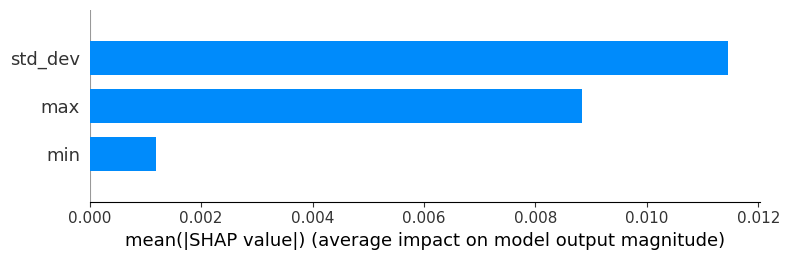

In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
pip install openmeteo-requests

In [ ]:
pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.7 MB/s eta 0:00:00


Calculating historical NDVI data (2018-2024)...
Processing year 2018...
Year 2018 processed successfully.
Processing year 2019...
Year 2019 processed successfully.
Processing year 2020...
Year 2020 processed successfully.
Processing year 2021...
Year 2021 processed successfully.
Processing year 2022...
Year 2022 processed successfully.
Processing year 2023...
Year 2023 processed successfully.
Processing year 2024...
Year 2024 processed successfully.
Historical NDVI data saved to 'historical_ndvi_2018_2024.csv'


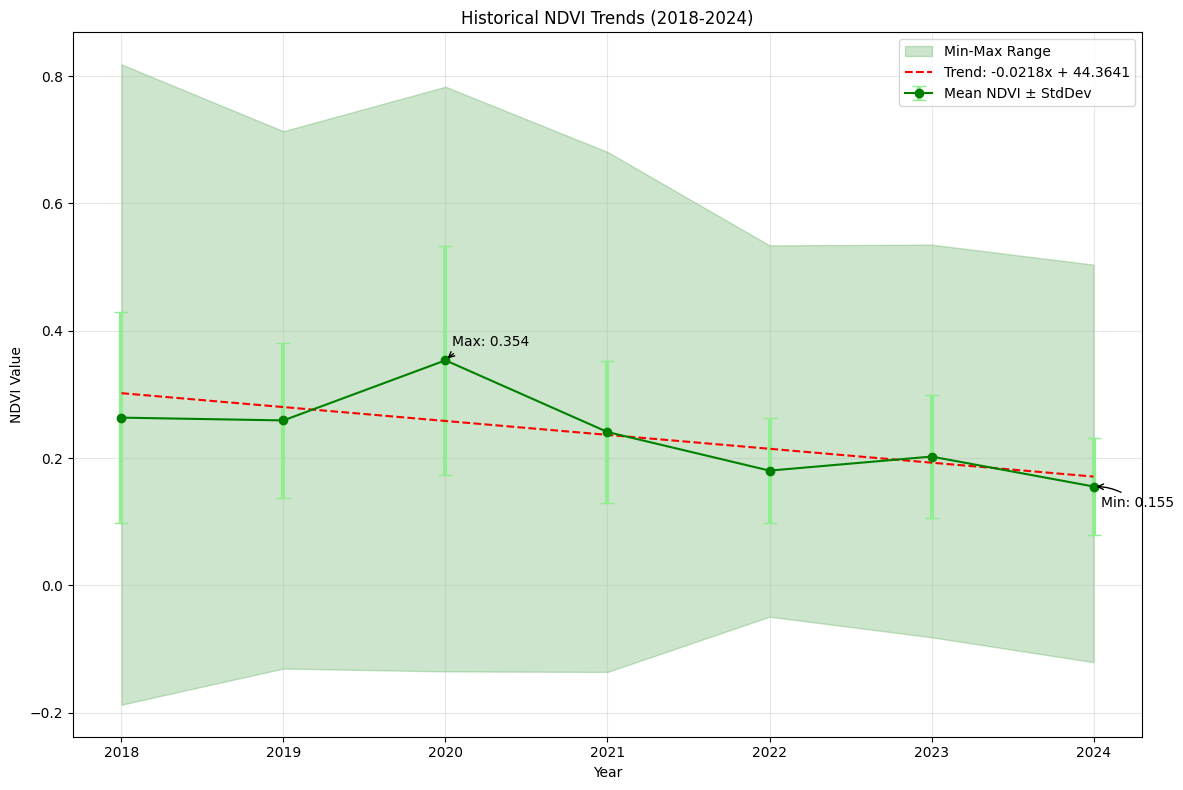

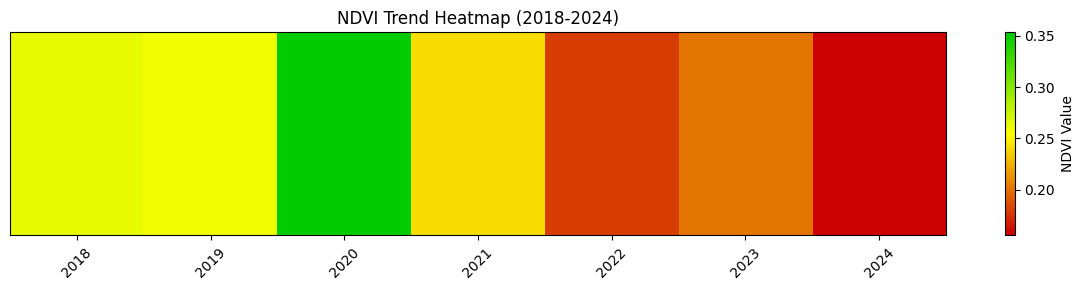

NDVI summary updated with historical data


In [ ]:
# Calculate Historical NDVI Data (2018-2024)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the time range
start_year = 2018
end_year = 2024

# Function to calculate annual NDVI statistics
def get_annual_ndvi_stats(year):
    # Define date range for the year
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Get Sentinel-2 collection (from 2015 onwards) or Landsat 8 (for 2013-2014)
    if year >= 2015:
        # Sentinel-2 data (available from 2015)
        collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                     .filterBounds(roi)
                     .filterDate(start_date, end_date)
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

        # Function to calculate NDVI for Sentinel-2
        def calc_ndvi(image):
            ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
            return image.addBands(ndvi)
    else:
        # Landsat 8 data (for 2013-2014)
        collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                     .filterBounds(roi)
                     .filterDate(start_date, end_date)
                     .filter(ee.Filter.lt('CLOUD_COVER', 20)))

        # Function to calculate NDVI for Landsat 8
        def calc_ndvi(image):
            # Scale the surface reflectance bands
            image = image.select(['SR_B5', 'SR_B4']).multiply(0.0000275).add(-0.2)
            ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
            return image.addBands(ndvi)

    # Map the NDVI calculation over the collection
    ndvi_collection = collection.map(calc_ndvi)

    # Create annual composite (median)
    annual_composite = ndvi_collection.select('NDVI').median()

    # Calculate statistics
    stats = annual_composite.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.minMax(),
            sharedInputs=True
        ),
        geometry=roi,
        scale=30,  # Using 30m resolution for consistency between Landsat and Sentinel
        maxPixels=1e9
    )

    # Return statistics as dictionary
    return {
        'year': year,
        'mean': stats.get('NDVI_mean').getInfo(),
        'std_dev': stats.get('NDVI_stdDev').getInfo(),
        'min': stats.get('NDVI_min').getInfo(),
        'max': stats.get('NDVI_max').getInfo()
    }

# Calculate NDVI statistics for each year
print("Calculating historical NDVI data (2018-2024)...")
historical_ndvi = []

for year in range(start_year, end_year + 1):
    print(f"Processing year {year}...")
    try:
        year_stats = get_annual_ndvi_stats(year)
        historical_ndvi.append(year_stats)
        print(f"Year {year} processed successfully.")
    except Exception as e:
        print(f"Error processing year {year}: {str(e)}")

# Convert to DataFrame
historical_df = pd.DataFrame(historical_ndvi)

# Save to CSV
historical_df.to_csv('historical_ndvi_2018_2023.csv', index=False)
print("Historical NDVI data saved to 'historical_ndvi_2018_2024.csv'")

# Visualize historical trends
plt.figure(figsize=(12, 8))

# Plot mean NDVI with error bars
plt.errorbar(
    historical_df['year'],
    historical_df['mean'],
    yerr=historical_df['std_dev'],
    fmt='o-',
    color='green',
    ecolor='lightgreen',
    elinewidth=3,
    capsize=5,
    label='Mean NDVI ± StdDev'
)

# Plot min and max as shaded area
plt.fill_between(
    historical_df['year'],
    historical_df['min'],
    historical_df['max'],
    alpha=0.2,
    color='green',
    label='Min-Max Range'
)

# Add trend line
z = np.polyfit(historical_df['year'], historical_df['mean'], 1)
p = np.poly1d(z)
plt.plot(historical_df['year'], p(historical_df['year']), "r--", label=f'Trend: {z[0]:.4f}x + {z[1]:.4f}')

plt.xlabel('Year')
plt.ylabel('NDVI Value')
plt.title('Historical NDVI Trends (2018-2024)')
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotations for significant years
max_year = historical_df.loc[historical_df['mean'].idxmax()]
min_year = historical_df.loc[historical_df['mean'].idxmin()]

plt.annotate(f"Max: {max_year['mean']:.3f}",
             xy=(max_year['year'], max_year['mean']),
             xytext=(5, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f"Min: {min_year['mean']:.3f}",
             xy=(min_year['year'], min_year['mean']),
             xytext=(5, -15), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

# Create heatmap visualization of yearly NDVI
years = historical_df['year'].tolist()
ndvi_values = historical_df['mean'].tolist()

# Create a custom colormap
colors = [(0.8, 0, 0), (1, 1, 0), (0, 0.8, 0)]  # Red -> Yellow -> Green
cmap = LinearSegmentedColormap.from_list('ndvi_cmap', colors, N=100)

# Create heatmap data
heatmap_data = np.array([ndvi_values])

plt.figure(figsize=(12, 3))
plt.imshow(heatmap_data, cmap=cmap, aspect='auto')
plt.colorbar(label='NDVI Value')
plt.yticks([])  # Hide y-axis
plt.xticks(range(len(years)), years, rotation=45)
plt.title('NDVI Trend Heatmap (2018-2024)')
plt.tight_layout()
plt.show()

# Update the ndvi_summary.json with historical data
import json

# Load existing summary
try:
    with open("ndvi_summary.json", "r") as f:
        ndvi_summary = json.load(f)
except FileNotFoundError:
    ndvi_summary = {}

# Add historical data
ndvi_summary["Historical"] = {
    "yearly_mean": {str(row['year']): row['mean'] for _, row in historical_df.iterrows()},
    "trend_slope": float(z[0]),
    "overall_mean": float(historical_df['mean'].mean()),
    "max_year": int(max_year['year']),
    "min_year": int(min_year['year'])
}

# Save updated summary
with open("ndvi_summary.json", "w") as f:
    json.dump(ndvi_summary, f, indent=4)

print("NDVI summary updated with historical data")

Calculating seasonal NDVI variations (2018-2024)...
Processing seasonal data for 2018...
Year 2018 seasonal data processed successfully.
Processing seasonal data for 2019...
Year 2019 seasonal data processed successfully.
Processing seasonal data for 2020...
Year 2020 seasonal data processed successfully.
Processing seasonal data for 2021...
Year 2021 seasonal data processed successfully.
Processing seasonal data for 2022...
Year 2022 seasonal data processed successfully.
Processing seasonal data for 2023...
Year 2023 seasonal data processed successfully.
Processing seasonal data for 2024...
Year 2024 seasonal data processed successfully.
Seasonal NDVI data saved to 'seasonal_ndvi_2018_2024.csv'


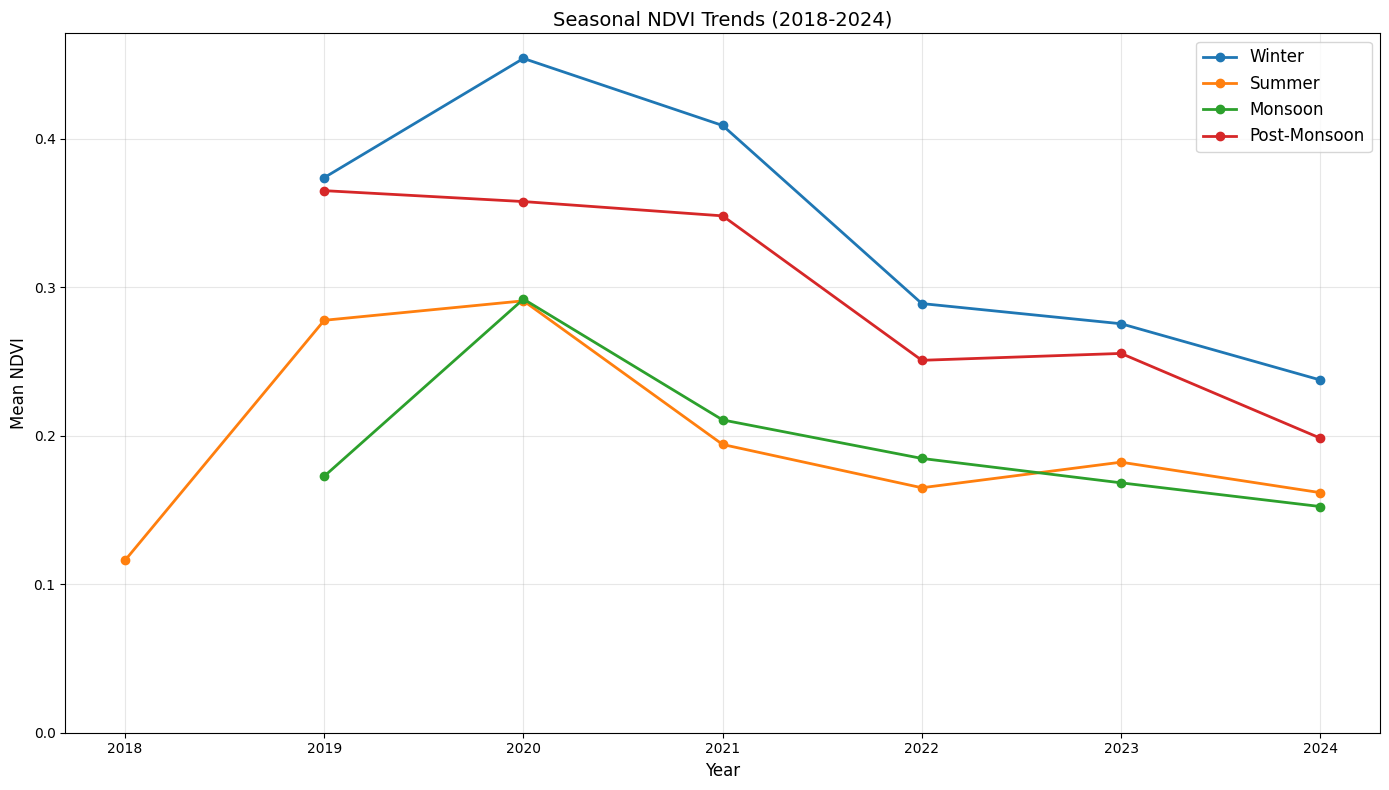

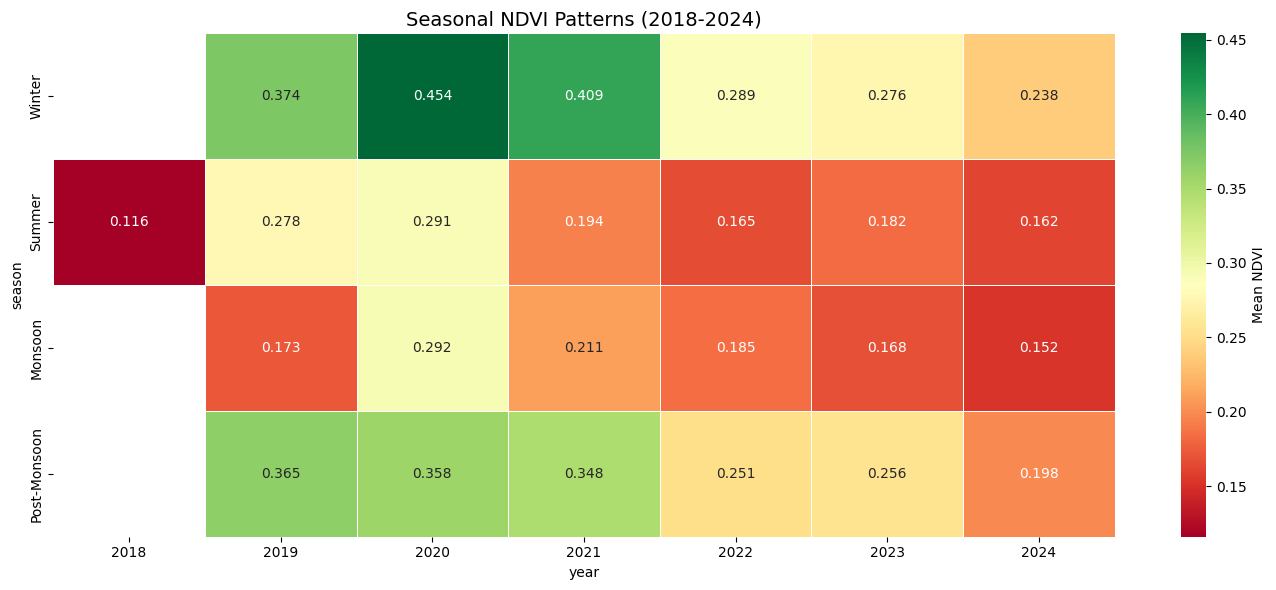

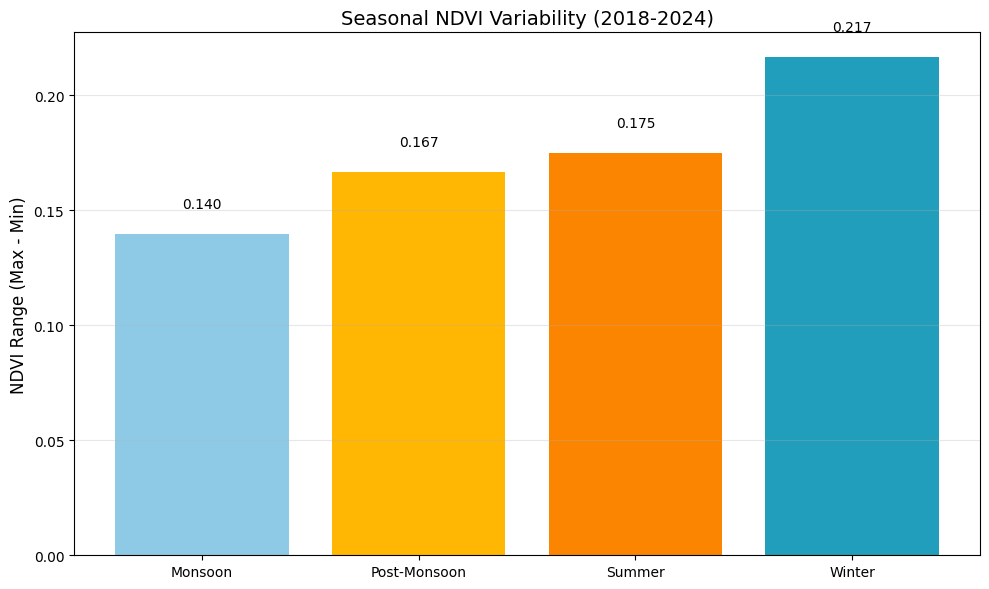

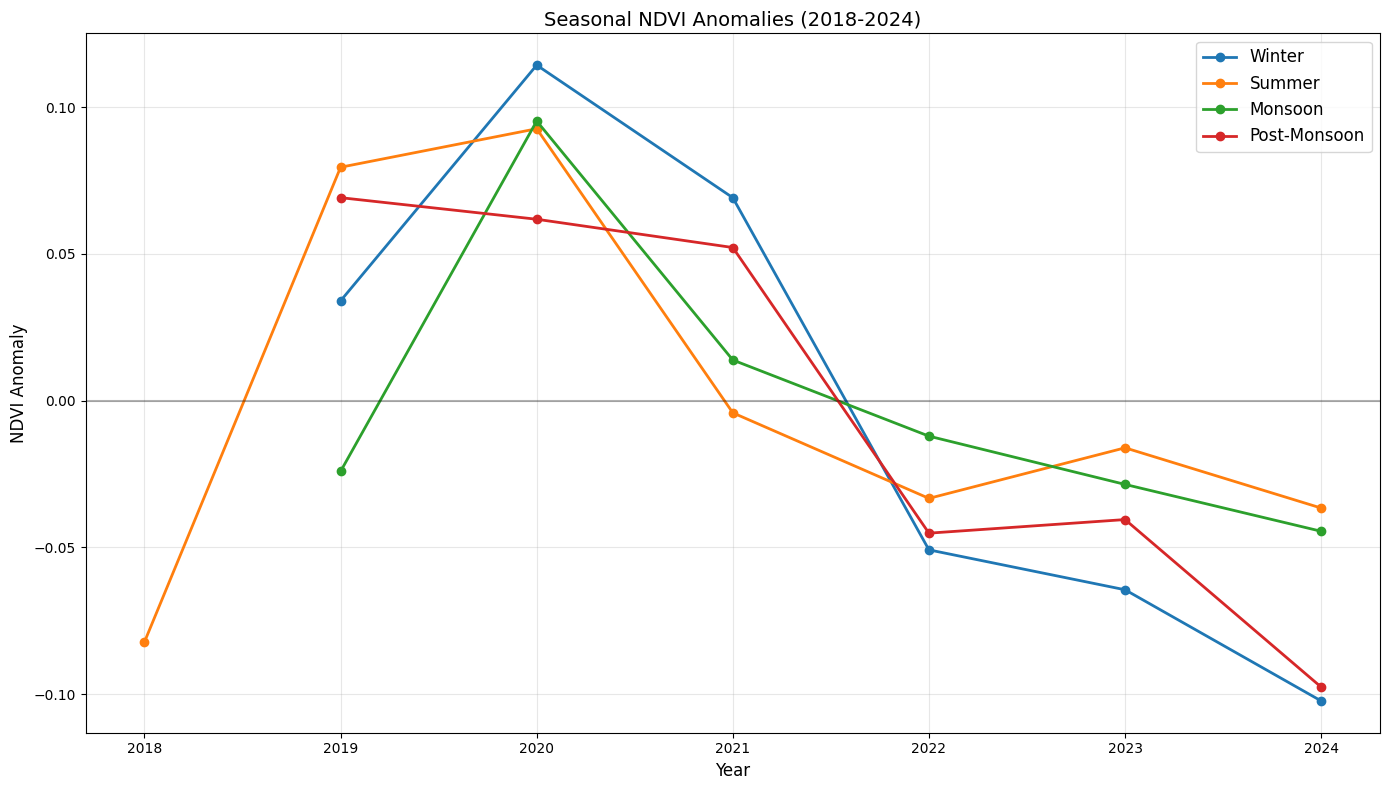

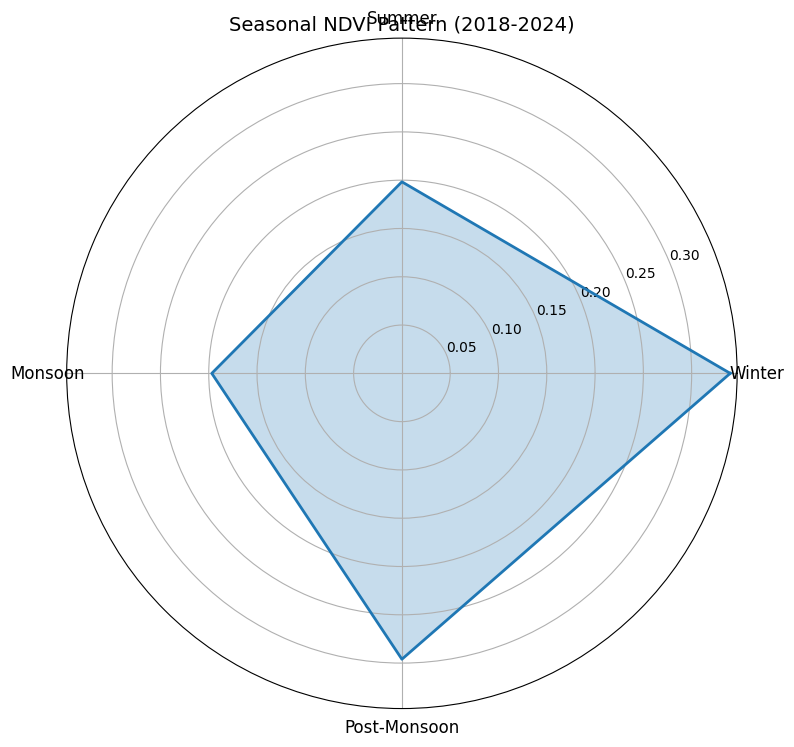

NDVI summary updated with seasonal historical data


In [ ]:
# Seasonal NDVI Variations (2018-2024)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar

# Define seasons
seasons = {
    'Winter': [12, 1, 2],
    'Summer': [3, 4, 5],
    'Monsoon': [6, 7, 8],
    'Post-Monsoon': [9, 10, 11]
}

# Updated year range
start_year = 2018
end_year = 2024

# Function to calculate seasonal NDVI for a specific year
def get_seasonal_ndvi(year):
    seasonal_data = {}

    for season_name, months in seasons.items():
        # Handle December of previous year for Winter
        season_months = []
        for month in months:
            if month == 12 and season_name == 'Winter':
                # December of previous year
                season_months.append((year-1, month))
            else:
                season_months.append((year, month))

        # Create a list to store all images for this season
        all_season_images = []

        for year_m, month in season_months:
            # Skip if year is before our start year
            if year_m < start_year:
                continue

            # Get days in month
            days_in_month = calendar.monthrange(year_m, month)[1]
            start_date = f'{year_m}-{month:02d}-01'
            end_date = f'{year_m}-{month:02d}-{days_in_month}'

            # Use Sentinel-2 data (available for our entire date range)
            collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                         .filterBounds(roi)
                         .filterDate(start_date, end_date)
                         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

            # Skip if no images for this month
            if collection.size().getInfo() == 0:
                continue

            # Calculate NDVI for each image
            def calc_ndvi(image):
                ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
                return image.addBands(ndvi)

            # Map NDVI calculation and get the NDVI band
            ndvi_collection = collection.map(calc_ndvi).select('NDVI')

            # Get median NDVI for this month
            monthly_ndvi = ndvi_collection.median()

            # Add to season images
            all_season_images.append(monthly_ndvi)

        # Skip if no data available for this season
        if not all_season_images:
            seasonal_data[season_name] = {
                'mean': None,
                'std_dev': None,
                'min': None,
                'max': None
            }
            continue

        # Create a multi-band image with all monthly NDVIs
        if len(all_season_images) == 1:
            seasonal_composite = all_season_images[0]
        else:
            # Create a collection and take the median
            seasonal_collection = ee.ImageCollection.fromImages(all_season_images)
            seasonal_composite = seasonal_collection.median()

        # Calculate statistics
        stats = seasonal_composite.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                reducer2=ee.Reducer.stdDev(),
                sharedInputs=True
            ).combine(
                reducer2=ee.Reducer.minMax(),
                sharedInputs=True
            ),
            geometry=roi,
            scale=10,  # Using 10m resolution for Sentinel-2
            maxPixels=1e9
        )

        # Store seasonal data
        try:
            seasonal_data[season_name] = {
                'mean': stats.get('NDVI_mean').getInfo(),
                'std_dev': stats.get('NDVI_stdDev').getInfo(),
                'min': stats.get('NDVI_min').getInfo(),
                'max': stats.get('NDVI_max').getInfo()
            }
        except Exception as e:
            print(f"Error getting stats for {season_name} in {year}: {str(e)}")
            seasonal_data[season_name] = {
                'mean': None,
                'std_dev': None,
                'min': None,
                'max': None
            }

    return seasonal_data

# Calculate seasonal NDVI for each year
print(f"Calculating seasonal NDVI variations ({start_year}-{end_year})...")
seasonal_ndvi_data = {}

for year in range(start_year, end_year + 1):
    print(f"Processing seasonal data for {year}...")
    try:
        seasonal_ndvi_data[year] = get_seasonal_ndvi(year)
        print(f"Year {year} seasonal data processed successfully.")
    except Exception as e:
        print(f"Error processing seasonal data for {year}: {str(e)}")

# Convert to DataFrame for easier analysis
seasonal_rows = []

for year, seasons_data in seasonal_ndvi_data.items():
    for season, stats in seasons_data.items():
        if stats['mean'] is not None:  # Skip seasons with no data
            seasonal_rows.append({
                'year': year,
                'season': season,
                'mean': stats['mean'],
                'std_dev': stats['std_dev'],
                'min': stats['min'],
                'max': stats['max']
            })

# Create DataFrame if we have data
if seasonal_rows:
    seasonal_df = pd.DataFrame(seasonal_rows)

    # Save to CSV
    seasonal_df.to_csv(f'seasonal_ndvi_{start_year}_{end_year}.csv', index=False)
    print(f"Seasonal NDVI data saved to 'seasonal_ndvi_{start_year}_{end_year}.csv'")

    # Visualize seasonal trends
    plt.figure(figsize=(14, 8))

    # Create line plot for each season
    for season in seasons.keys():
        season_data = seasonal_df[seasonal_df['season'] == season]
        if not season_data.empty:
            plt.plot(
                season_data['year'],
                season_data['mean'],
                'o-',
                label=season,
                linewidth=2
            )

    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean NDVI', fontsize=12)
    plt.title(f'Seasonal NDVI Trends ({start_year}-{end_year})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(range(start_year, end_year + 1))
    plt.ylim(bottom=0)  # Start y-axis from 0 for better visualization
    plt.tight_layout()
    plt.show()

    # Create heatmap of seasonal patterns
    pivot_df = seasonal_df.pivot(index='season', columns='year', values='mean')

    # Sort seasons in chronological order
    season_order = ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']
    pivot_df = pivot_df.reindex(season_order)

    plt.figure(figsize=(14, 6))
    sns.heatmap(
        pivot_df,
        cmap='RdYlGn',
        annot=True,
        fmt='.3f',
        linewidths=.5,
        cbar_kws={'label': 'Mean NDVI'}
    )
    plt.title(f'Seasonal NDVI Patterns ({start_year}-{end_year})', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Calculate seasonal variability
    seasonal_variability = seasonal_df.groupby('season')['mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
    seasonal_variability['range'] = seasonal_variability['max'] - seasonal_variability['min']
    seasonal_variability['cv'] = seasonal_variability['std'] / seasonal_variability['mean'] * 100  # Coefficient of variation

    # Plot seasonal variability
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        seasonal_variability['season'],
        seasonal_variability['range'],
        color=['#8ECAE6', '#FFB703', '#FB8500', '#219EBC']
    )

    # Add data labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.01,
            f'{height:.3f}',
            ha='center',
            va='bottom'
        )

    plt.ylabel('NDVI Range (Max - Min)', fontsize=12)
    plt.title(f'Seasonal NDVI Variability ({start_year}-{end_year})', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate year-to-year seasonal anomalies
    seasonal_means = seasonal_df.groupby('season')['mean'].mean().to_dict()
    seasonal_df['anomaly'] = seasonal_df.apply(lambda row: row['mean'] - seasonal_means[row['season']], axis=1)

    # Plot seasonal anomalies
    plt.figure(figsize=(14, 8))
    for season in seasons.keys():
        season_data = seasonal_df[seasonal_df['season'] == season]
        if not season_data.empty:
            plt.plot(
                season_data['year'],
                season_data['anomaly'],
                'o-',
                label=season,
                linewidth=2
            )

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('NDVI Anomaly', fontsize=12)
    plt.title(f'Seasonal NDVI Anomalies ({start_year}-{end_year})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(range(start_year, end_year + 1))
    plt.tight_layout()
    plt.show()

    # Create a radar chart for seasonal patterns
    def radar_chart(df, value_column):
        # Group by season and calculate mean
        season_means = df.groupby('season')[value_column].mean().reindex(season_order)

        # Number of variables
        N = len(season_means)

        # What will be the angle of each axis in the plot
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop

        # Values for the plot
        values = season_means.values.tolist()
        values += values[:1]  # Close the loop

        # Create the plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Draw one axis per variable and add labels
        plt.xticks(angles[:-1], season_means.index, fontsize=12)

        # Draw the chart
        ax.plot(angles, values, linewidth=2, linestyle='solid', label='Mean NDVI')
        ax.fill(angles, values, alpha=0.25)

        # Add title
        plt.title(f'Seasonal NDVI Pattern ({start_year}-{end_year})', fontsize=14)

        return fig, ax

    # Create radar chart
    radar_fig, radar_ax = radar_chart(seasonal_df, 'mean')
    plt.tight_layout()
    plt.show()

    # Update the ndvi_summary.json with seasonal historical data
    import json

    # Load existing summary
    try:
        with open("ndvi_summary.json", "r") as f:
            ndvi_summary = json.load(f)
    except FileNotFoundError:
        ndvi_summary = {}

    # Add seasonal historical data
    ndvi_summary["Seasonal_Historical"] = {
        season: {
            "mean_across_years": float(seasonal_variability[seasonal_variability['season'] == season]['mean'].values[0]),
            "variability": float(seasonal_variability[seasonal_variability['season'] == season]['cv'].values[0]),
            "yearly_means": {
                str(year): float(mean)
                for year, mean in seasonal_df[seasonal_df['season'] == season][['year', 'mean']].values
            }
        }
        for season in seasons.keys() if season in seasonal_variability['season'].values
    }

    # Save updated summary
    with open("ndvi_summary.json", "w") as f:
        json.dump(ndvi_summary, f, indent=4)

    print("NDVI summary updated with seasonal historical data")
else:
    print("No seasonal data was collected. Please check if the selected area has available satellite imagery.")

Getting climate data for coordinates: 30.8712°N, 75.9812°E
Fetching climate data from Open-Meteo...
Coordinates: 30.89630889892578°N 75.94082641601562°E
Elevation: 252.0 m above sea level
Timezone: b'Asia/Kolkata' (b'GMT+5:30')
Climate data saved to 'climate_data_2018_present.csv' (2613 days)


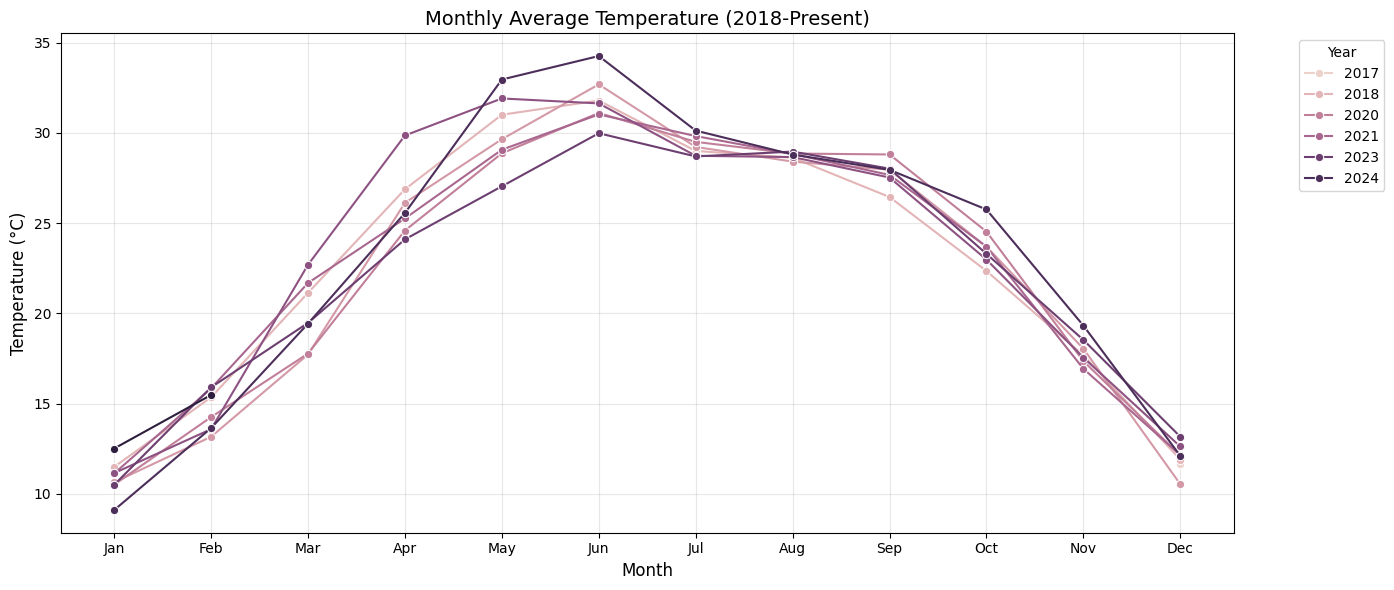

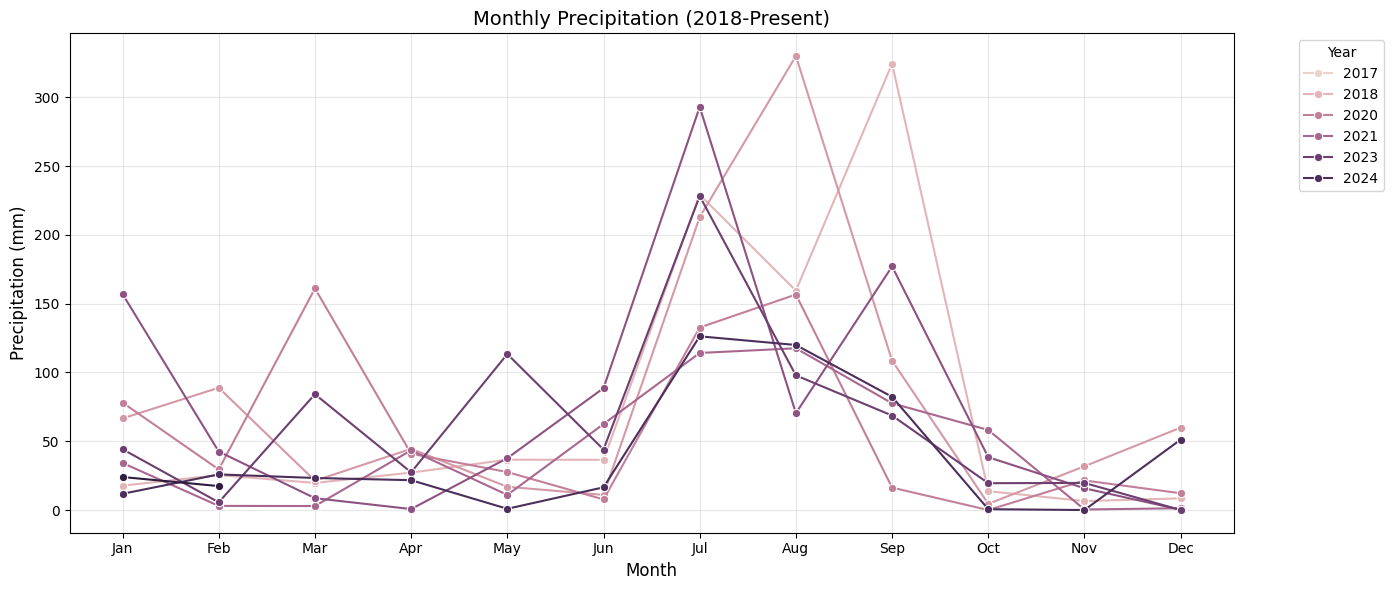

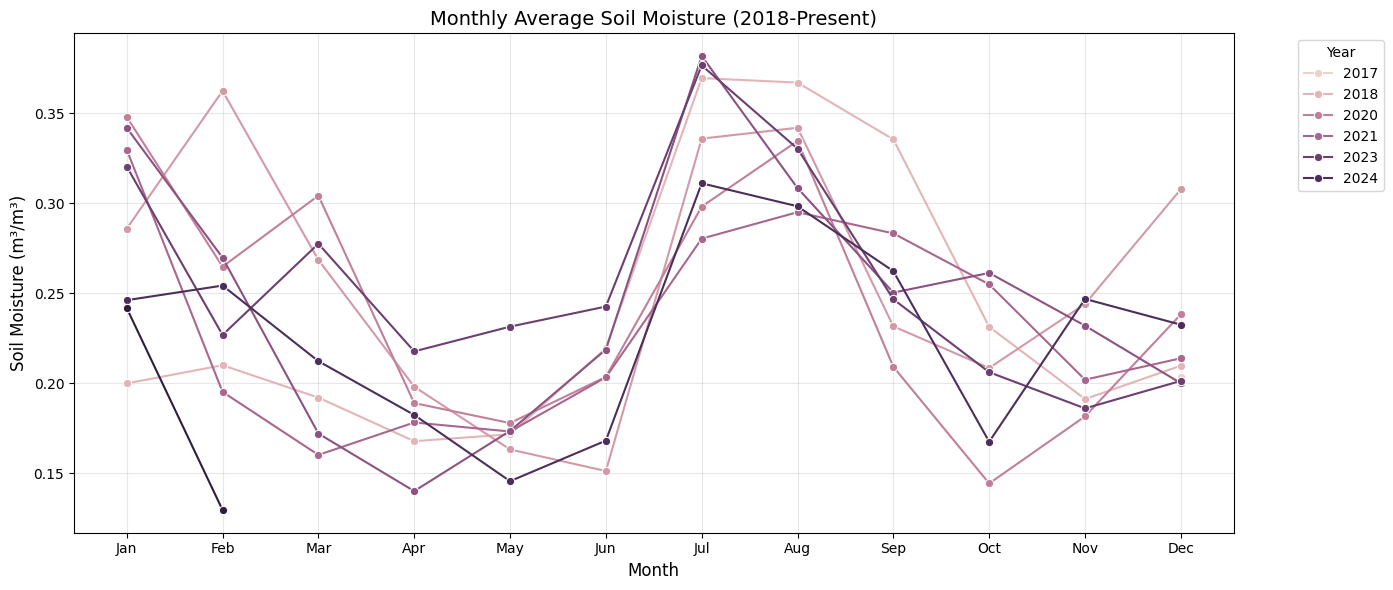

<Figure size 1400x800 with 0 Axes>

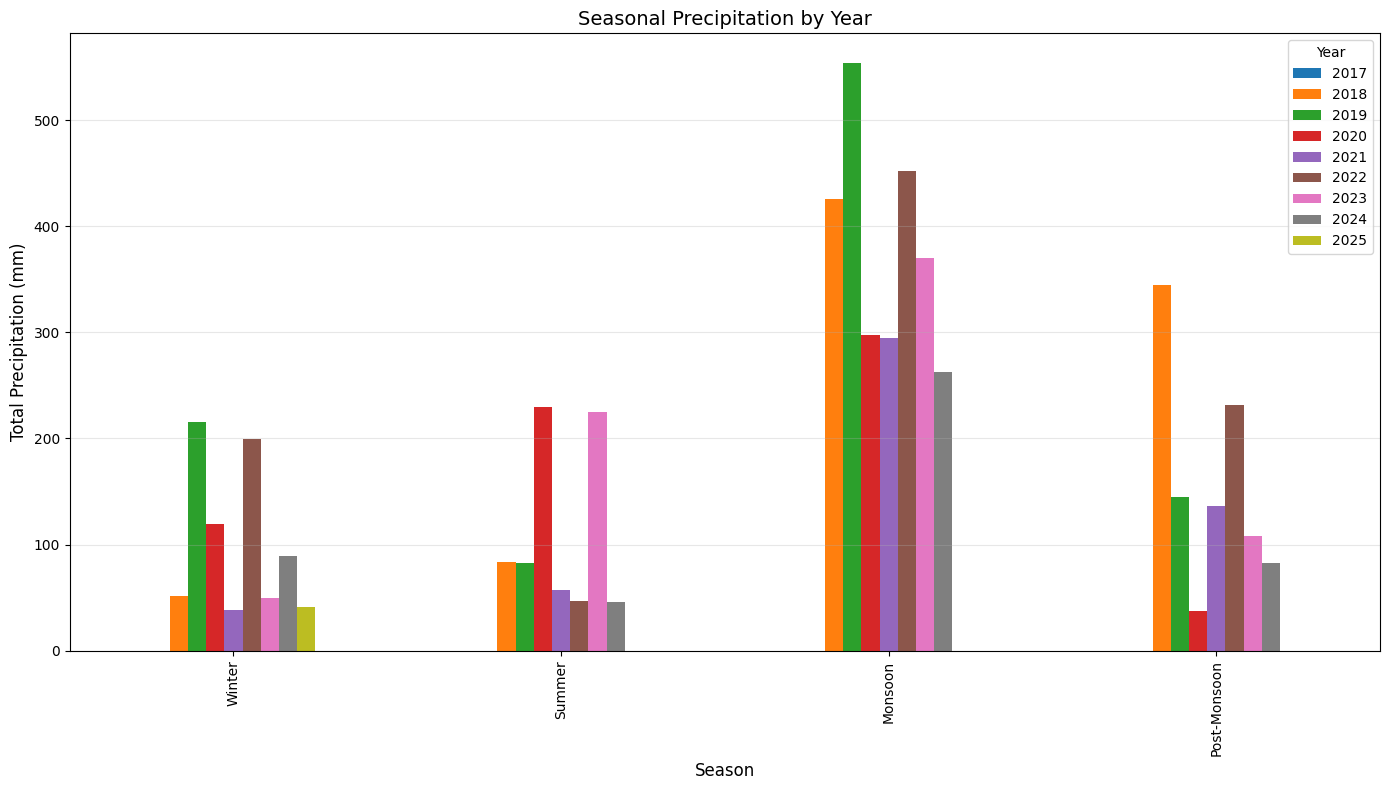

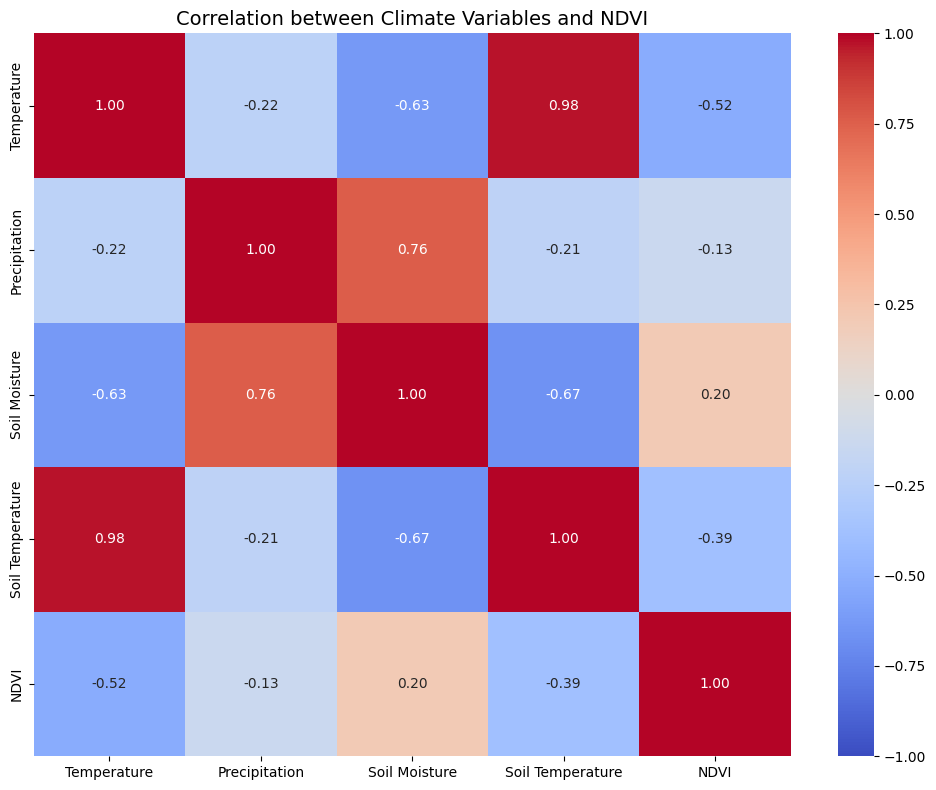

Climate-NDVI correlation analysis completed.


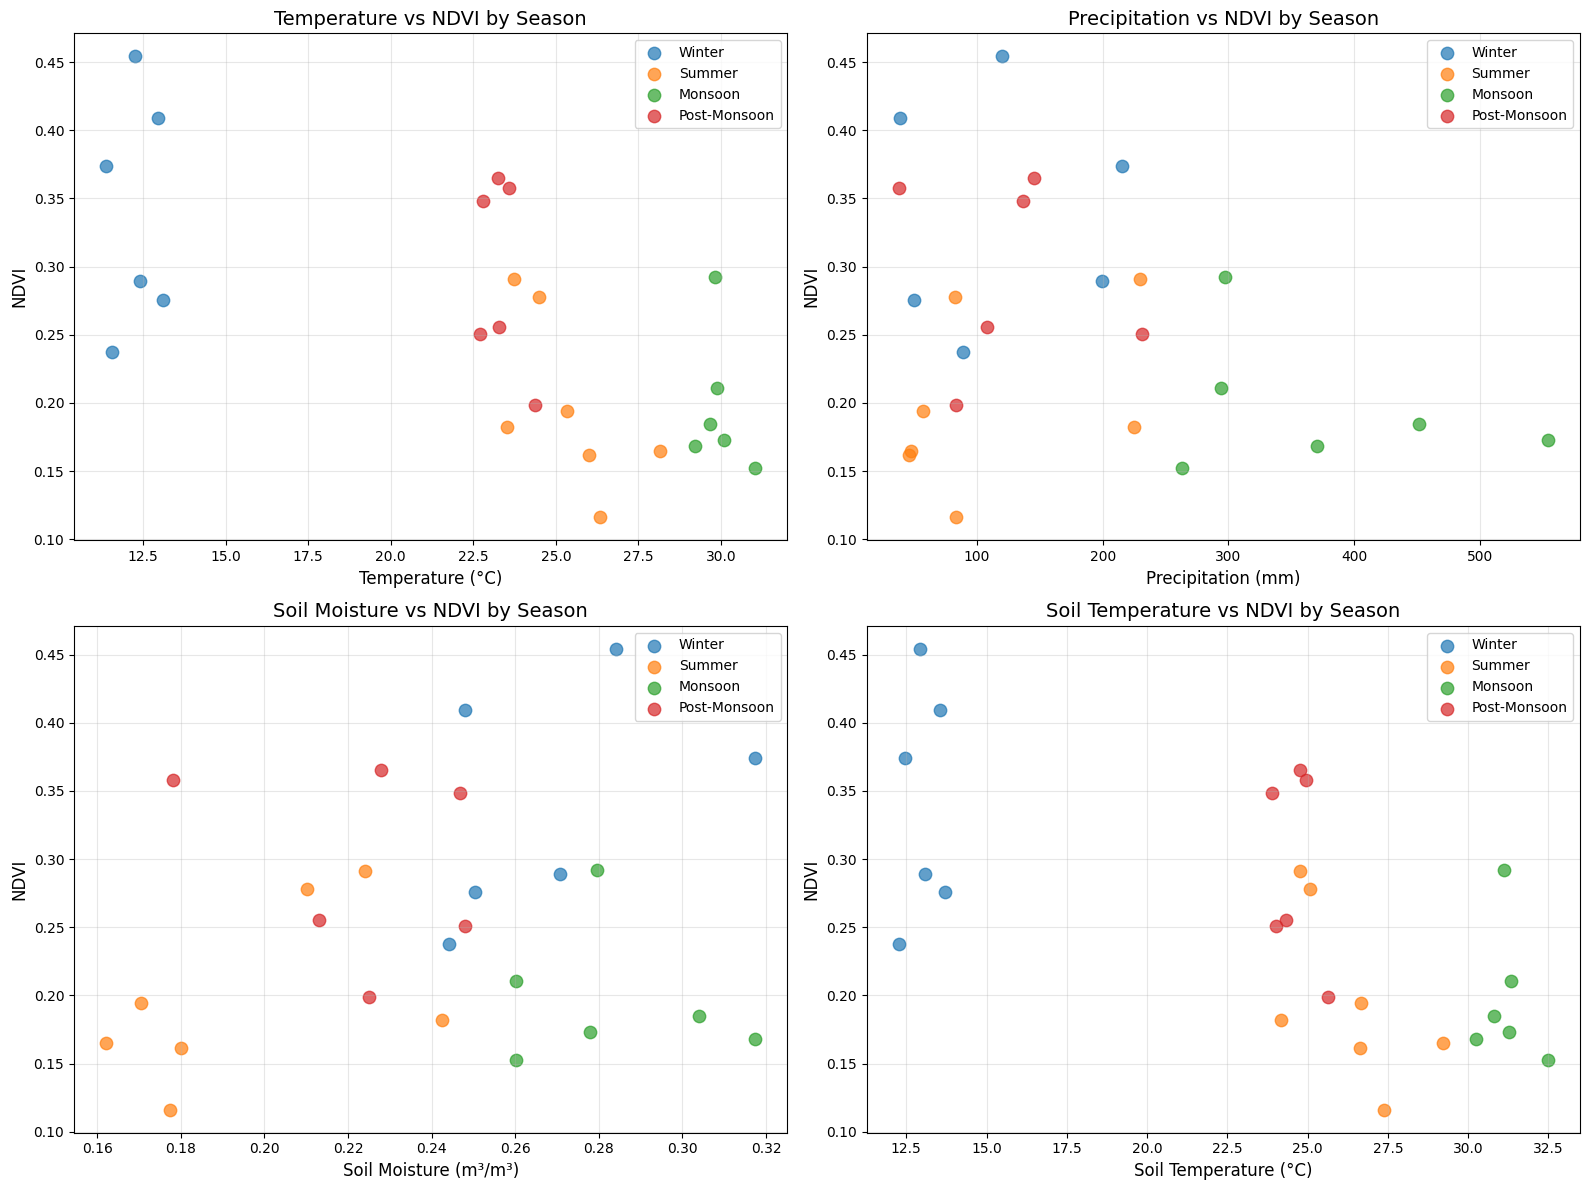

Combined climate-NDVI visualization created.
NDVI summary updated with climate data

--- About Open-Meteo Caching ---

Open-Meteo uses a caching system to improve performance and reduce API load:

1. How the cache works:
   - The 'requests_cache' library stores API responses locally in a '.cache' directory
   - 'expire_after=-1' means the cache never expires (data is stored permanently)
   - This reduces redundant API calls for the same data

2. Benefits for your project:
   - Faster execution after the first run
   - Reduced API usage and potential rate limiting
   - Works offline once data is cached

3. Long-term usability:
   - The cached data will remain available indefinitely
   - You can run the project later without needing new API calls for historical data
   - Only new dates not in the cache will trigger API requests

4. Considerations:
   - The cache size will grow over time as you request more data
   - If weather reanalysis models are updated, cached data won't reflect thes

In [ ]:
# Climate Data Analysis (2018-Present)
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from retry_requests import retry
import ee

# Get coordinates from the user-selected area (ROI)
# Instead of using centroid which can cause errors, we'll use the bounds
roi_bounds = roi.bounds().getInfo()['coordinates'][0]
# Calculate the center of the bounding box manually
lon_min = min(point[0] for point in roi_bounds)
lon_max = max(point[0] for point in roi_bounds)
lat_min = min(point[1] for point in roi_bounds)
lat_max = max(point[1] for point in roi_bounds)

longitude = (lon_min + lon_max) / 2
latitude = (lat_min + lat_max) / 2

print(f"Getting climate data for coordinates: {latitude:.4f}°N, {longitude:.4f}°E")

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Set date range from 2018 to current date
start_date = "2018-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Make sure all required weather variables are listed here
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "daily": [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "soil_temperature_0_to_7cm_mean",
        "soil_moisture_0_to_7cm_mean"
    ],
    "timezone": "auto"
}

print("Fetching climate data from Open-Meteo...")
responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m above sea level")
print(f"Timezone: {response.Timezone()} ({response.TimezoneAbbreviation()})")

# Process daily data
daily = response.Daily()
daily_temp_max = daily.Variables(0).ValuesAsNumpy()
daily_temp_min = daily.Variables(1).ValuesAsNumpy()
daily_temp_mean = daily.Variables(2).ValuesAsNumpy()
daily_precip_sum = daily.Variables(3).ValuesAsNumpy()
daily_rain_sum = daily.Variables(4).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(5).ValuesAsNumpy()
daily_precip_hours = daily.Variables(6).ValuesAsNumpy()
daily_soil_temp = daily.Variables(7).ValuesAsNumpy()
daily_soil_moisture = daily.Variables(8).ValuesAsNumpy()

# Create DataFrame with daily data
daily_data = {"date": pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s"),
    end=pd.to_datetime(daily.TimeEnd(), unit="s"),
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)}

daily_data["temp_max"] = daily_temp_max
daily_data["temp_min"] = daily_temp_min
daily_data["temp_mean"] = daily_temp_mean
daily_data["precip_sum"] = daily_precip_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precip_hours"] = daily_precip_hours
daily_data["soil_temp"] = daily_soil_temp
daily_data["soil_moisture"] = daily_soil_moisture

# Create DataFrame
climate_df = pd.DataFrame(data=daily_data)

# Add year, month, and season columns
climate_df['year'] = climate_df['date'].dt.year
climate_df['month'] = climate_df['date'].dt.month
climate_df['day'] = climate_df['date'].dt.day

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

climate_df['season'] = climate_df['month'].apply(get_season)

# Save the full dataset
climate_df.to_csv('climate_data_2018_present.csv', index=False)
print(f"Climate data saved to 'climate_data_2018_present.csv' ({len(climate_df)} days)")

# Calculate monthly averages
monthly_climate = climate_df.groupby(['year', 'month']).agg({
    'temp_mean': 'mean',
    'precip_sum': 'sum',
    'soil_moisture': 'mean'
}).reset_index()

# Calculate seasonal averages
seasonal_climate = climate_df.groupby(['year', 'season']).agg({
    'temp_mean': 'mean',
    'precip_sum': 'sum',
    'soil_moisture': 'mean',
    'soil_temp': 'mean'
}).reset_index()

# Visualize temperature trends
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_climate, x='month', y='temp_mean', hue='year', marker='o')
plt.title('Monthly Average Temperature (2018-Present)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(alpha=0.3)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize precipitation trends
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_climate, x='month', y='precip_sum', hue='year', marker='o')
plt.title('Monthly Precipitation (2018-Present)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(alpha=0.3)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize soil moisture trends
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_climate, x='month', y='soil_moisture', hue='year', marker='o')
plt.title('Monthly Average Soil Moisture (2018-Present)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Soil Moisture (m³/m³)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(alpha=0.3)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Create seasonal comparison chart
plt.figure(figsize=(14, 8))
seasonal_pivot = seasonal_climate.pivot(index='season', columns='year', values='precip_sum')
seasonal_pivot = seasonal_pivot.reindex(['Winter', 'Summer', 'Monsoon', 'Post-Monsoon'])

ax = seasonal_pivot.plot(kind='bar', figsize=(14, 8))
plt.title('Seasonal Precipitation by Year', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Precipitation (mm)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

# Create correlation heatmap between climate variables
# Calculate yearly averages first
yearly_climate = climate_df.groupby('year').agg({
    'temp_mean': 'mean',
    'precip_sum': 'sum',
    'soil_moisture': 'mean',
    'soil_temp': 'mean'
}).reset_index()

# Load NDVI data for correlation analysis
try:
    # Try to find the seasonal NDVI data first
    try:
        ndvi_df = pd.read_csv('seasonal_ndvi_2018_2024.csv')
        # Group by year to get yearly averages
        ndvi_yearly = ndvi_df.groupby('year')['mean'].mean().reset_index()
    except:
        # Fall back to historical NDVI data if available
        ndvi_df = pd.read_csv('historical_ndvi_2018_2023.csv')
        ndvi_yearly = ndvi_df

    # Merge climate and NDVI data
    merged_data = pd.merge(yearly_climate, ndvi_yearly, left_on='year', right_on='year', how='inner')

    # Calculate correlation matrix
    corr_columns = ['temp_mean', 'precip_sum', 'soil_moisture', 'soil_temp', 'mean']
    corr_matrix = merged_data[corr_columns].corr()

    # Rename columns for better readability
    corr_matrix.columns = ['Temperature', 'Precipitation', 'Soil Moisture', 'Soil Temperature', 'NDVI']
    corr_matrix.index = ['Temperature', 'Precipitation', 'Soil Moisture', 'Soil Temperature', 'NDVI']

    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation between Climate Variables and NDVI', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("Climate-NDVI correlation analysis completed.")
except Exception as e:
    print(f"Could not perform correlation analysis with NDVI data: {str(e)}")

# Create a combined visualization of climate and NDVI
try:
    # Try to use seasonal data first
    try:
        ndvi_seasonal = pd.read_csv('seasonal_ndvi_2018_2024.csv')
        # Get seasonal averages
        ndvi_seasonal_avg = ndvi_seasonal.groupby(['year', 'season'])['mean'].mean().reset_index()
    except:
        # If not available, create a placeholder
        print("Seasonal NDVI data not found. Skipping combined visualization.")
        raise FileNotFoundError

    # Merge with climate data
    combined_seasonal = pd.merge(
        seasonal_climate,
        ndvi_seasonal_avg,
        on=['year', 'season'],
        how='inner'
    )

    # Create a multi-panel figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot temperature vs NDVI
    for season in ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']:
        season_data = combined_seasonal[combined_seasonal['season'] == season]
        axes[0, 0].scatter(
            season_data['temp_mean'],
            season_data['mean'],
            label=season,
            s=80,
            alpha=0.7
        )

    axes[0, 0].set_xlabel('Temperature (°C)', fontsize=12)
    axes[0, 0].set_ylabel('NDVI', fontsize=12)
    axes[0, 0].set_title('Temperature vs NDVI by Season', fontsize=14)
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].legend()

    # Plot precipitation vs NDVI
    for season in ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']:
        season_data = combined_seasonal[combined_seasonal['season'] == season]
        axes[0, 1].scatter(
            season_data['precip_sum'],
            season_data['mean'],
            label=season,
            s=80,
            alpha=0.7
        )

    axes[0, 1].set_xlabel('Precipitation (mm)', fontsize=12)
    axes[0, 1].set_ylabel('NDVI', fontsize=12)
    axes[0, 1].set_title('Precipitation vs NDVI by Season', fontsize=14)
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].legend()

    # Plot soil moisture vs NDVI
    for season in ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']:
        season_data = combined_seasonal[combined_seasonal['season'] == season]
        axes[1, 0].scatter(
            season_data['soil_moisture'],
            season_data['mean'],
            label=season,
            s=80,
            alpha=0.7
        )

    axes[1, 0].set_xlabel('Soil Moisture (m³/m³)', fontsize=12)
    axes[1, 0].set_ylabel('NDVI', fontsize=12)
    axes[1, 0].set_title('Soil Moisture vs NDVI by Season', fontsize=14)
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].legend()

    # Plot soil temperature vs NDVI
    for season in ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']:
        season_data = combined_seasonal[combined_seasonal['season'] == season]
        axes[1, 1].scatter(
            season_data['soil_temp'],
            season_data['mean'],
            label=season,
            s=80,
            alpha=0.7
        )

    axes[1, 1].set_xlabel('Soil Temperature (°C)', fontsize=12)
    axes[1, 1].set_ylabel('NDVI', fontsize=12)
    axes[1, 1].set_title('Soil Temperature vs NDVI by Season', fontsize=14)
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    print("Combined climate-NDVI visualization created.")
except Exception as e:
    print(f"Could not create combined visualization: {str(e)}")

# Update the ndvi_summary.json with climate data
import json

# Load existing summary
try:
    with open("ndvi_summary.json", "r") as f:
        ndvi_summary = json.load(f)
except FileNotFoundError:
    ndvi_summary = {}

# Add climate data summary
ndvi_summary["Climate"] = {
    "location": {
        "latitude": float(latitude),
        "longitude": float(longitude)
    },
    "yearly_averages": {
        str(int(year)): {
            "temperature": float(temp),
            "precipitation": float(precip),
            "soil_moisture": float(soil_m),
            "soil_temperature": float(soil_t)
        }
        for year, temp, precip, soil_m, soil_t in yearly_climate[['year', 'temp_mean', 'precip_sum', 'soil_moisture', 'soil_temp']].values
    },
    "seasonal_patterns": {
        season: {
            str(int(year)): {
                "temperature": float(temp),
                "precipitation": float(precip),
                "soil_moisture": float(soil_m)
            }
            for year, temp, precip, soil_m in seasonal_climate[seasonal_climate['season'] == season][['year', 'temp_mean', 'precip_sum', 'soil_moisture']].values
        }
        for season in ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']
    }
}

# Save updated summary
with open("ndvi_summary.json", "w") as f:
    json.dump(ndvi_summary, f, indent=4)

print("NDVI summary updated with climate data")

# Explanation of Open-Meteo caching
print("\n--- About Open-Meteo Caching ---")
print("""
Open-Meteo uses a caching system to improve performance and reduce API load:

1. How the cache works:
   - The 'requests_cache' library stores API responses locally in a '.cache' directory
   - 'expire_after=-1' means the cache never expires (data is stored permanently)
   - This reduces redundant API calls for the same data

2. Benefits for your project:
   - Faster execution after the first run
   - Reduced API usage and potential rate limiting
   - Works offline once data is cached

3. Long-term usability:
   - The cached data will remain available indefinitely
   - You can run the project later without needing new API calls for historical data
   - Only new dates not in the cache will trigger API requests

4. Considerations:
   - The cache size will grow over time as you request more data
   - If weather reanalysis models are updated, cached data won't reflect these updates
   - For critical applications, consider setting an expiration time

To clear the cache and get fresh data, delete the '.cache' directory or use:
cache_session = requests_cache.CachedSession('.cache', expire_after=0)
""")

Extracting soil data for the selected area...
Soil data extracted successfully!

Soil Properties by Depth:
       Depth        pH  Organic Carbon (g/kg)  Bulk Density (kg/m³)  Clay (%)  \
0     0-10cm  7.542178               1.866447              1.521310  2.947747   
1    10-30cm  7.555516               1.728607              1.527824  3.036733   
2    30-60cm  7.667708               1.001403              1.565404  3.182780   
3   60-100cm  7.741556               0.395876              1.570640  3.280245   
4  100-200cm  7.828001               0.204214              1.587735  3.229117   

   Sand (%)   Silt (%)  
0  3.307908  93.744345  
1  3.253108  93.710159  
2  3.168736  93.648484  
3  3.103863  93.615892  
4  3.151311  93.619572  

Soil Health Assessment:
pH: 7.55 (Score: 68.0/100)
Organic Carbon: 1.80 g/kg (Score: 9.0/100)
Bulk Density: 1.52 kg/m³ (Score: 0.0/100)
Texture: Clay 3.0%, Sand 3.3% (Score: 41.3/100)
Overall Soil Health Score: 29.6/100


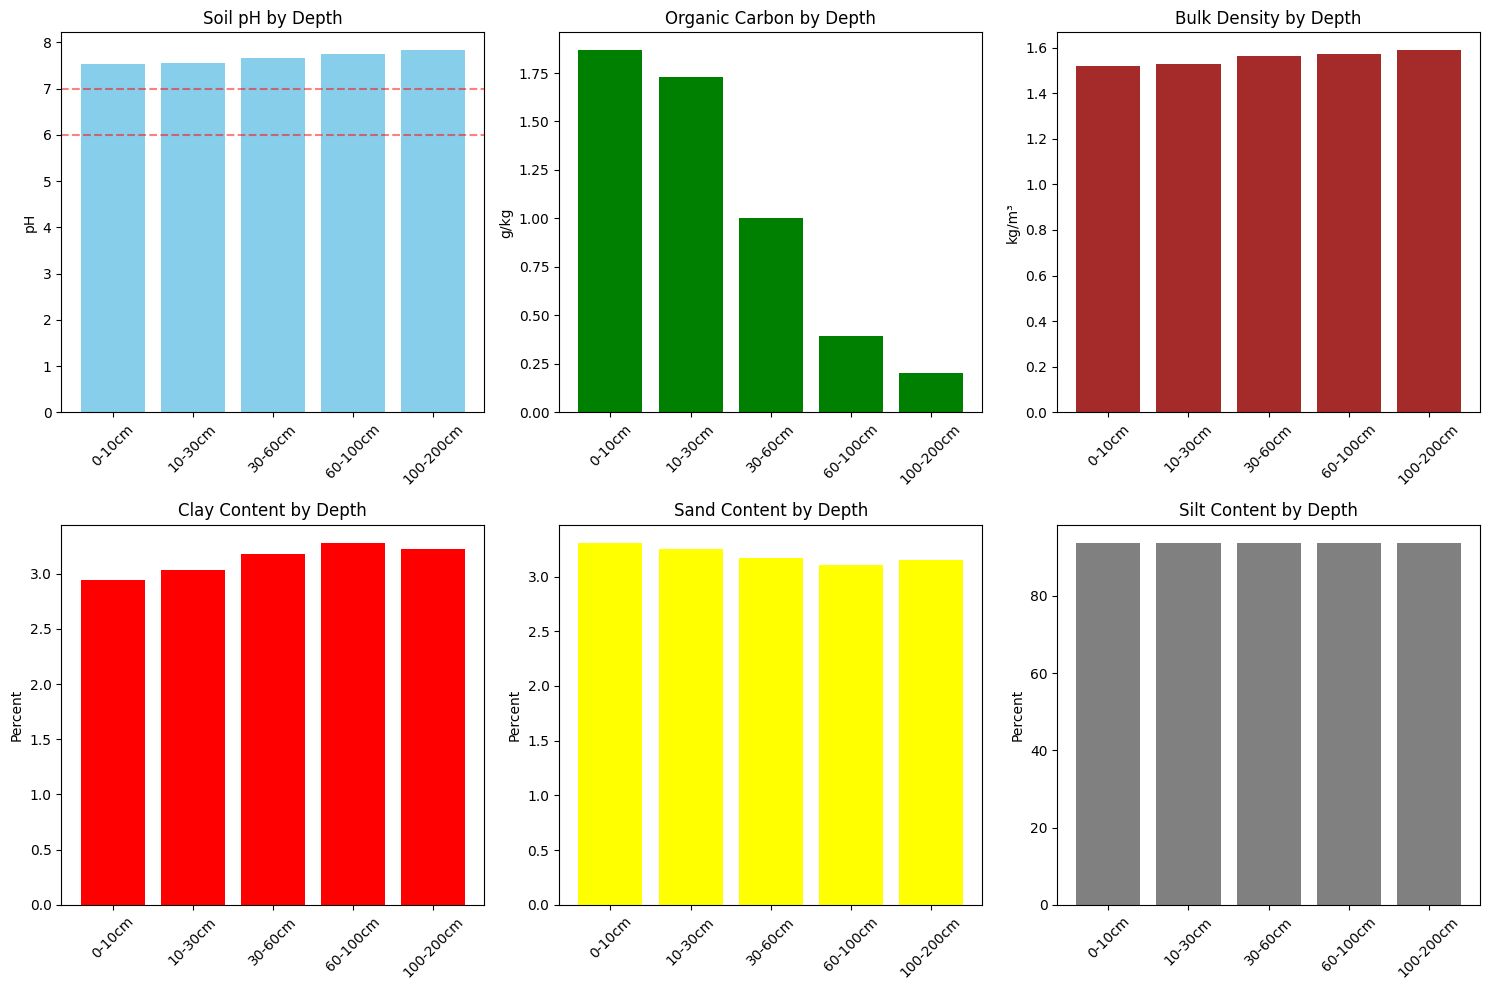

NDVI summary updated with soil data


In [ ]:
# Soil Data Analysis using available datasets
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.path import Path
import geemap

print("Extracting soil data for the selected area...")

# Load soil datasets from Google Earth Engine
# Using only datasets that are confirmed to be publicly accessible
soil_ph = ee.Image("OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02")
soil_organic_carbon = ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")
soil_bulk_density = ee.Image("OpenLandMap/SOL/SOL_BULKDENS-FINEEARTH_USDA-4A1H_M/v02")
soil_clay = ee.Image("OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02")
soil_sand = ee.Image("OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02")

# Function to extract soil data for a specific depth
def extract_soil_data(roi):
    # Define depths (in cm)
    depths = [0, 10, 30, 60, 100, 200]
    depth_labels = ["0-10cm", "10-30cm", "30-60cm", "60-100cm", "100-200cm"]

    # Dictionary to store results
    soil_data = {}

    # Extract OpenLandMap data (these are already separated by depth)
    # pH (band names: b0, b10, b30, b60, b100, b200)
    ph_values = []
    for i in range(len(depths)-1):
        band_name = f"b{depths[i]}"
        ph_value = soil_ph.select(band_name).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=250,
            maxPixels=1e9
        ).get(band_name).getInfo()

        # pH values are scaled by 10
        if ph_value is not None:
            ph_value = ph_value / 10

        ph_values.append(ph_value)

    soil_data["pH"] = {depth_labels[i]: ph_values[i] for i in range(len(depth_labels))}

    # Organic Carbon (band names: b0, b10, b30, b60, b100, b200)
    oc_values = []
    for i in range(len(depths)-1):
        band_name = f"b{depths[i]}"
        oc_value = soil_organic_carbon.select(band_name).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=250,
            maxPixels=1e9
        ).get(band_name).getInfo()

        # OC values are in g/kg
        oc_values.append(oc_value)

    soil_data["organic_carbon"] = {depth_labels[i]: oc_values[i] for i in range(len(depth_labels))}

    # Bulk Density (band names: b0, b10, b30, b60, b100, b200)
    bd_values = []
    for i in range(len(depths)-1):
        band_name = f"b{depths[i]}"
        bd_value = soil_bulk_density.select(band_name).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=250,
            maxPixels=1e9
        ).get(band_name).getInfo()

        # BD values are in kg/m³ x 100
        if bd_value is not None:
            bd_value = bd_value / 100

        bd_values.append(bd_value)

    soil_data["bulk_density"] = {depth_labels[i]: bd_values[i] for i in range(len(depth_labels))}

    # Clay Content (band names: b0, b10, b30, b60, b100, b200)
    clay_values = []
    for i in range(len(depths)-1):
        band_name = f"b{depths[i]}"
        clay_value = soil_clay.select(band_name).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=250,
            maxPixels=1e9
        ).get(band_name).getInfo()

        # Clay values are in g/kg (permille)
        if clay_value is not None:
            clay_value = clay_value / 10  # Convert to percentage

        clay_values.append(clay_value)

    soil_data["clay_content"] = {depth_labels[i]: clay_values[i] for i in range(len(depth_labels))}

    # Sand Content (band names: b0, b10, b30, b60, b100, b200)
    sand_values = []
    for i in range(len(depths)-1):
        band_name = f"b{depths[i]}"
        sand_value = soil_sand.select(band_name).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=250,
            maxPixels=1e9
        ).get(band_name).getInfo()

        # Sand values are in g/kg (permille)
        if sand_value is not None:
            sand_value = sand_value / 10  # Convert to percentage

        sand_values.append(sand_value)

    soil_data["sand_content"] = {depth_labels[i]: sand_values[i] for i in range(len(depth_labels))}

    return soil_data

# Extract soil data for the ROI
try:
    soil_data = extract_soil_data(roi)
    print("Soil data extracted successfully!")

    # Create data for DataFrame
    soil_df_data = []

    # Fill the data list
    for depth in soil_data["pH"].keys():
        # Calculate silt content
        clay = soil_data["clay_content"][depth] if soil_data["clay_content"][depth] is not None else np.nan
        sand = soil_data["sand_content"][depth] if soil_data["sand_content"][depth] is not None else np.nan

        if not np.isnan(clay) and not np.isnan(sand):
            silt = 100 - clay - sand
        else:
            silt = np.nan

        soil_df_data.append({
            'Depth': depth,
            'pH': soil_data["pH"][depth],
            'Organic Carbon (g/kg)': soil_data["organic_carbon"][depth],
            'Bulk Density (kg/m³)': soil_data["bulk_density"][depth],
            'Clay (%)': clay,
            'Sand (%)': sand,
            'Silt (%)': silt
        })

    # Create DataFrame from the list
    soil_df = pd.DataFrame(soil_df_data)

    # Display the DataFrame
    print("\nSoil Properties by Depth:")
    print(soil_df)

    # Calculate topsoil (0-30cm) averages
    topsoil_ph = np.nanmean([soil_data["pH"]["0-10cm"], soil_data["pH"]["10-30cm"]])
    topsoil_oc = np.nanmean([soil_data["organic_carbon"]["0-10cm"], soil_data["organic_carbon"]["10-30cm"]])
    topsoil_bd = np.nanmean([soil_data["bulk_density"]["0-10cm"], soil_data["bulk_density"]["10-30cm"]])
    topsoil_clay = np.nanmean([soil_data["clay_content"]["0-10cm"], soil_data["clay_content"]["10-30cm"]])
    topsoil_sand = np.nanmean([soil_data["sand_content"]["0-10cm"], soil_data["sand_content"]["10-30cm"]])

    # Calculate soil health score (0-100)
    # pH optimal range: 6.0-7.5
    ph_score = 100 - min(abs(topsoil_ph - 6.75) * 40, 100)

    # Organic carbon optimal range: >20 g/kg
    oc_score = min(topsoil_oc * 5, 100)

    # Bulk density optimal range: <1.4 kg/m³
    bd_score = max(100 - max(0, (topsoil_bd - 1.0) * 200), 0)

    # Texture score (loam is ideal)
    if not np.isnan(topsoil_clay) and not np.isnan(topsoil_sand):
        topsoil_silt = 100 - topsoil_clay - topsoil_sand
        texture_score = 100 - (abs(topsoil_clay - 25) + abs(topsoil_sand - 40) + abs(topsoil_silt - 35)) / 2
    else:
        texture_score = 50  # Default if data is missing

    # Overall soil health score
    soil_health_score = (ph_score + oc_score + bd_score + texture_score) / 4

    print("\nSoil Health Assessment:")
    print(f"pH: {topsoil_ph:.2f} (Score: {ph_score:.1f}/100)")
    print(f"Organic Carbon: {topsoil_oc:.2f} g/kg (Score: {oc_score:.1f}/100)")
    print(f"Bulk Density: {topsoil_bd:.2f} kg/m³ (Score: {bd_score:.1f}/100)")
    print(f"Texture: Clay {topsoil_clay:.1f}%, Sand {topsoil_sand:.1f}% (Score: {texture_score:.1f}/100)")
    print(f"Overall Soil Health Score: {soil_health_score:.1f}/100")

    # Create visualizations
    try:
        # 1. Create bar chart of soil properties by depth
        plt.figure(figsize=(15, 10))

        # pH
        plt.subplot(2, 3, 1)
        plt.bar(soil_df['Depth'], soil_df['pH'], color='skyblue')
        plt.title('Soil pH by Depth')
        plt.ylabel('pH')
        plt.xticks(rotation=45)
        plt.axhline(y=7, color='r', linestyle='--', alpha=0.5)
        plt.axhline(y=6, color='r', linestyle='--', alpha=0.5)

        # Organic Carbon
        plt.subplot(2, 3, 2)
        plt.bar(soil_df['Depth'], soil_df['Organic Carbon (g/kg)'], color='green')
        plt.title('Organic Carbon by Depth')
        plt.ylabel('g/kg')
        plt.xticks(rotation=45)

        # Bulk Density
        plt.subplot(2, 3, 3)
        plt.bar(soil_df['Depth'], soil_df['Bulk Density (kg/m³)'], color='brown')
        plt.title('Bulk Density by Depth')
        plt.ylabel('kg/m³')
        plt.xticks(rotation=45)

        # Clay Content
        plt.subplot(2, 3, 4)
        plt.bar(soil_df['Depth'], soil_df['Clay (%)'], color='red')
        plt.title('Clay Content by Depth')
        plt.ylabel('Percent')
        plt.xticks(rotation=45)

        # Sand Content
        plt.subplot(2, 3, 5)
        plt.bar(soil_df['Depth'], soil_df['Sand (%)'], color='yellow')
        plt.title('Sand Content by Depth')
        plt.ylabel('Percent')
        plt.xticks(rotation=45)

        # Silt Content
        plt.subplot(2, 3, 6)
        plt.bar(soil_df['Depth'], soil_df['Silt (%)'], color='gray')
        plt.title('Silt Content by Depth')
        plt.ylabel('Percent')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # 2. Create soil suitability map
        try:
            # Create suitability layers
            # pH suitability (optimal range: 6.0-7.5)
            ph_suitability = soil_ph.select('b0').divide(10).expression(
                '100 - min(abs(b(0) - 6.75) * 40, 100)'
            )

            # Organic carbon suitability (higher is better)
            oc_suitability = soil_organic_carbon.select('b0').expression(
                'min(b(0) * 5, 100)'
            )

            # Combined suitability
            soil_suitability = ph_suitability.add(oc_suitability).divide(2)

            # Create a map
            soil_map = geemap.Map()
            soil_map.centerObject(roi, 12)

            # Add the soil suitability layer
            soil_map.addLayer(
                soil_suitability,
                {'min': 0, 'max': 100, 'palette': ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850']},
                'Soil Suitability'
            )

            # Add the ROI
            soil_map.addLayer(roi, {'color': 'black'}, 'Study Area')

            # Add a legend
            soil_map.add_legend(
                title="Soil Suitability Index",
                colors=['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850'],
                keys=['Very Poor', 'Poor', 'Moderate', 'Good', 'Very Good', 'Excellent']
            )

            # Display the map
            soil_map
        except Exception as e:
            print(f"Could not create soil suitability map: {str(e)}")
    except Exception as e:
        print(f"Error creating visualizations: {str(e)}")

    # Function to determine soil texture class
    def get_soil_texture_class(clay, sand):
        if np.isnan(clay) or np.isnan(sand):
            return "Unknown (insufficient data)"

        silt = 100 - clay - sand

        if clay >= 40:
            return "Clay"
        elif clay >= 35 and sand <= 45:
            return "Clay Loam"
        elif clay >= 35 and sand > 45:
            return "Sandy Clay"
        elif clay >= 25 and sand <= 20:
            return "Silty Clay Loam"
        elif clay >= 25 and sand > 45:
            return "Sandy Clay Loam"
        elif clay >= 25 and sand <= 45 and sand > 20:
            return "Clay Loam"
        elif clay < 25 and sand <= 50 and clay >= 10:
            return "Loam"
        elif clay < 25 and sand <= 20 and clay >= 10:
            return "Silty Loam"
        elif clay < 10 and sand <= 15:
            return "Silt"
        elif clay < 25 and sand > 50 and clay >= 10:
            return "Sandy Loam"
        elif clay < 10 and sand > 85:
            return "Sand"
        elif clay < 10 and sand <= 85 and sand > 70:
            return "Loamy Sand"
        else:
            return "Unknown"

    # Update the ndvi_summary.json with soil data
    import json

    # Load existing summary
    try:
        with open("ndvi_summary.json", "r") as f:
            ndvi_summary = json.load(f)
    except FileNotFoundError:
        ndvi_summary = {}

    # Add soil data summary
    ndvi_summary["Soil"] = {
        "topsoil": {  # 0-30cm average
            "pH": float(topsoil_ph) if not np.isnan(topsoil_ph) else None,
            "organic_carbon_g_kg": float(topsoil_oc) if not np.isnan(topsoil_oc) else None,
            "clay_percent": float(topsoil_clay) if not np.isnan(topsoil_clay) else None,
            "sand_percent": float(topsoil_sand) if not np.isnan(topsoil_sand) else None,
            "silt_percent": float(100 - topsoil_clay - topsoil_sand) if not np.isnan(topsoil_clay) and not np.isnan(topsoil_sand) else None
        },
        "soil_health_score": float(soil_health_score),
        "soil_texture_class": get_soil_texture_class(topsoil_clay, topsoil_sand)
    }

    # Save updated summary
    with open("ndvi_summary.json", "w") as f:
        json.dump(ndvi_summary, f, indent=4)

    print("NDVI summary updated with soil data")

except Exception as e:
    print(f"Error in soil data analysis: {str(e)}")
    print("Using simplified soil analysis with available datasets...")

    # Simplified analysis with just pH and organic carbon
    try:
        # Extract just pH and organic carbon for topsoil
        topsoil_ph_value = soil_ph.select('b0').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=250,
            maxPixels=1e9
        ).get('b0').getInfo()

        if topsoil_ph_value is not None:
            topsoil_ph_value = topsoil_ph_value / 10

        topsoil_oc_value = soil_organic_carbon.select('b0').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=250,
            maxPixels=1e9
        ).get('b0').getInfo()

        print(f"Topsoil pH: {topsoil_ph_value}")
        print(f"Topsoil Organic Carbon: {topsoil_oc_value} g/kg")

        # Create a simple soil suitability map
        soil_map = geemap.Map()
        soil_map.centerObject(roi, 12)

        # Add the pH layer
        soil_map.addLayer(
            soil_ph.select('b0').divide(10).clip(roi),
            {'min': 4, 'max': 8, 'palette': ['#d73027', '#fc8d59', '#fee08b', '#1a9850', '#4575b4']},
            'Soil pH'
        )

        # Add the ROI
        soil_map.addLayer(roi, {'color': 'black'}, 'Study Area')

        # Add a legend
        soil_map.add_legend(
            title="Soil pH",
            colors=['#d73027', '#fc8d59', '#fee08b', '#1a9850', '#4575b4'],
            keys=['Acidic (4-5)', 'Slightly Acidic (5-6)', 'Neutral (6-7)', 'Slightly Alkaline (7-8)', 'Alkaline (>8)']
        )

        # Display the map
        soil_map

        # Update the ndvi_summary.json with limited soil data
        import json

        # Load existing summary
        try:
            with open("ndvi_summary.json", "r") as f:
                ndvi_summary = json.load(f)
        except FileNotFoundError:
            ndvi_summary = {}

        # Add soil data summary
        ndvi_summary["Soil"] = {
            "topsoil": {
                "pH": float(topsoil_ph_value) if topsoil_ph_value is not None else None,
                "organic_carbon_g_kg": float(topsoil_oc_value) if topsoil_oc_value is not None else None
            },
            "note": "Limited soil data available. Only pH and organic carbon could be retrieved."
        }

        # Save updated summary
        with open("ndvi_summary.json", "w") as f:
            json.dump(ndvi_summary, f, indent=4)

        print("NDVI summary updated with limited soil data")

    except Exception as e:
        print(f"Error in simplified soil analysis: {str(e)}")
        print("Could not retrieve soil data. Please check your internet connection and Earth Engine access.")

In [ ]:
# SHAP Visualization Examples for NDVI Analysis with Enhanced NDVI Impact
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import json
import os

# Create directory for visualizations if it doesn't exist
os.makedirs("shap_visualizations", exist_ok=True)

# Load data from ndvi_summary.json
try:
    with open("ndvi_summary.json", "r") as f:
        ndvi_summary = json.load(f)

    print("Successfully loaded NDVI summary data")
except FileNotFoundError:
    print("ndvi_summary.json not found. Please run the NDVI analysis first.")
    ndvi_summary = {}

# Create a function to prepare data for SHAP analysis with enhanced NDVI features
def prepare_data_for_shap():
    # Extract soil data
    soil_features = {}
    if 'Soil' in ndvi_summary and 'topsoil' in ndvi_summary['Soil']:
        topsoil = ndvi_summary['Soil']['topsoil']
        soil_features = {
            'soil_ph': topsoil.get('pH', np.nan),
            'soil_organic_carbon': topsoil.get('organic_carbon_g_kg', np.nan)
        }

    # Extract climate data
    climate_features = {}
    if 'Climate' in ndvi_summary:
        climate_data = ndvi_summary['Climate']

        # Extract location data if available
        if 'location' in climate_data:
            location = climate_data['location']
            climate_features.update({
                'latitude': location.get('latitude', np.nan),
                'longitude': location.get('longitude', np.nan)
            })

        # Extract yearly averages if available
        yearly_temps = []
        yearly_precip = []
        yearly_soil_moisture = []

        if 'yearly_averages' in climate_data:
            yearly_data = climate_data['yearly_averages']
            for year, data in yearly_data.items():
                if isinstance(data, dict):
                    if 'temperature' in data:
                        yearly_temps.append(data['temperature'])
                    if 'precipitation' in data:
                        yearly_precip.append(data['precipitation'])
                    if 'soil_moisture' in data:
                        yearly_soil_moisture.append(data['soil_moisture'])

        if yearly_temps:
            climate_features.update({
                'avg_temperature': np.mean(yearly_temps),
                'max_yearly_temp': np.max(yearly_temps),
                'min_yearly_temp': np.min(yearly_temps),
                'temp_variability': np.std(yearly_temps) if len(yearly_temps) > 1 else 0
            })

        if yearly_precip:
            climate_features.update({
                'avg_precipitation': np.mean(yearly_precip),
                'max_yearly_precip': np.max(yearly_precip),
                'min_yearly_precip': np.min(yearly_precip),
                'precip_variability': np.std(yearly_precip) if len(yearly_precip) > 1 else 0
            })

        if yearly_soil_moisture:
            climate_features.update({
                'avg_soil_moisture': np.mean(yearly_soil_moisture),
                'max_soil_moisture': np.max(yearly_soil_moisture),
                'min_soil_moisture': np.min(yearly_soil_moisture)
            })

    # Extract NDVI data
    ndvi_features = {}

    # Extract from Historical section
    if 'Historical' in ndvi_summary:
        historical = ndvi_summary['Historical']
        ndvi_features.update({
            'ndvi_overall_mean': historical.get('overall_mean', np.nan),
            'ndvi_trend_slope': historical.get('trend_slope', np.nan),
            'ndvi_max_year': historical.get('max_year', np.nan),
            'ndvi_min_year': historical.get('min_year', np.nan)
        })

        # Extract yearly means if available
        if 'yearly_mean' in historical:
            yearly_means = historical['yearly_mean']
            yearly_ndvi_values = list(yearly_means.values())

            if yearly_ndvi_values:
                ndvi_features.update({
                    'ndvi_yearly_mean': np.mean(yearly_ndvi_values),
                    'ndvi_yearly_max': np.max(yearly_ndvi_values),
                    'ndvi_yearly_min': np.min(yearly_ndvi_values),
                    'ndvi_yearly_range': np.max(yearly_ndvi_values) - np.min(yearly_ndvi_values),
                    'ndvi_yearly_variability': np.std(yearly_ndvi_values) if len(yearly_ndvi_values) > 1 else 0
                })

                # Add recent years' NDVI if available
                recent_years = sorted(yearly_means.keys())[-3:]
                for year in recent_years:
                    if year in yearly_means:
                        ndvi_features[f'ndvi_{int(float(year))}'] = yearly_means[year]

    # Extract from Seasonal_Historical section
    if 'Seasonal_Historical' in ndvi_summary:
        seasonal = ndvi_summary['Seasonal_Historical']

        for season in ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']:
            if season in seasonal:
                season_data = seasonal[season]
                ndvi_features.update({
                    f'ndvi_{season.lower()}_mean': season_data.get('mean_across_years', np.nan),
                    f'ndvi_{season.lower()}_variability': season_data.get('variability', np.nan)
                })

                # Extract recent year's seasonal data if available
                if 'yearly_means' in season_data:
                    yearly_means = season_data['yearly_means']
                    recent_year = sorted(yearly_means.keys())[-1] if yearly_means else None
                    if recent_year:
                        ndvi_features[f'ndvi_{season.lower()}_recent'] = yearly_means[recent_year]

    # Combine all features
    all_features = {**soil_features, **climate_features, **ndvi_features}

    # Create a DataFrame with the features
    df = pd.DataFrame([all_features])

    # Fill missing values with column means or defaults if all values are missing
    for col in df.columns:
        if pd.isna(df[col].iloc[0]):
            if col.startswith('ndvi_'):
                df[col] = 0.3  # Default NDVI value
            elif col.startswith('soil_'):
                df[col] = 6.5 if 'ph' in col else 10  # Default soil values
            elif 'temperature' in col or 'temp' in col:
                df[col] = 22  # Default temperature
            elif 'precip' in col or 'rainfall' in col:
                df[col] = 800  # Default precipitation
            elif 'moisture' in col:
                df[col] = 0.25  # Default soil moisture
            else:
                df[col] = 0  # Default for other values

    return df

# Generate synthetic data for model training
def generate_synthetic_data(df, n_samples=100):
    synthetic_df = pd.DataFrame(columns=df.columns)

    for i in range(n_samples):
        # Create a new row with random variations around the original values
        new_row = {}
        for col in df.columns:
            base_value = df[col].iloc[0]
            # Add noise proportional to the value
            noise_scale = max(abs(base_value) * 0.2, 0.1)
            new_row[col] = base_value + np.random.normal(0, noise_scale)

        synthetic_df = pd.concat([synthetic_df, pd.DataFrame([new_row])], ignore_index=True)

    return synthetic_df

# Generate synthetic target data for different scenarios
def generate_target_data(df, target_variable):
    # Get NDVI features
    ndvi_cols = [col for col in df.columns if col.startswith('ndvi_')]

    # Get climate features
    climate_cols = [col for col in df.columns if any(term in col for term in ['temp', 'precip', 'moisture'])]

    # Get soil features
    soil_cols = [col for col in df.columns if col.startswith('soil_')]

    if target_variable == 'vegetation_health':
        # Vegetation health (0-100)
        # Base health
        base = 40

        # NDVI contribution (30%)
        ndvi_contribution = 0
        if 'ndvi_overall_mean' in df.columns:
            ndvi_contribution += 15 * df['ndvi_overall_mean'] / 0.5
        if 'ndvi_trend_slope' in df.columns:
            ndvi_contribution += 15 * (df['ndvi_trend_slope'] + 0.05) / 0.1  # Positive trend is good

        # Climate contribution (40%)
        climate_contribution = 0
        if 'avg_precipitation' in df.columns:
            climate_contribution += 20 * df['avg_precipitation'] / 1000  # More rain is better up to a point
        if 'avg_temperature' in df.columns:
            climate_contribution += 20 * (1 - abs(df['avg_temperature'] - 22) / 15)  # Optimal temp around 22°C

        # Soil contribution (30%)
        soil_contribution = 0
        if 'soil_organic_carbon' in df.columns:
            soil_contribution += 15 * df['soil_organic_carbon'] / 20
        if 'soil_ph' in df.columns:
            soil_contribution += 15 * (1 - abs(df['soil_ph'] - 6.5) / 3)  # Optimal pH around 6.5

        # Combine all contributions
        y = base + ndvi_contribution + climate_contribution + soil_contribution
        return np.clip(y + np.random.normal(0, 5, size=len(df)), 0, 100)

    elif target_variable == 'crop_yield':
        # Crop yield (tons/hectare)
        # Base yield
        base = 2

        # NDVI contribution (40%)
        ndvi_contribution = 0
        if 'ndvi_overall_mean' in df.columns:
            ndvi_contribution += 2 * df['ndvi_overall_mean'] / 0.5
        if 'ndvi_summer_mean' in df.columns:
            ndvi_contribution += 2 * df['ndvi_summer_mean'] / 0.5

        # Climate contribution (30%)
        climate_contribution = 0
        if 'avg_precipitation' in df.columns:
            climate_contribution += 1.5 * df['avg_precipitation'] / 1000
        if 'avg_temperature' in df.columns:
            climate_contribution += 1.5 * (1 - abs(df['avg_temperature'] - 22) / 15)

        # Soil contribution (30%)
        soil_contribution = 0
        if 'soil_organic_carbon' in df.columns:
            soil_contribution += 1.5 * df['soil_organic_carbon'] / 20
        if 'soil_ph' in df.columns:
            soil_contribution += 1.5 * (1 - abs(df['soil_ph'] - 6.5) / 3)

        # Combine all contributions
        y = base + ndvi_contribution + climate_contribution + soil_contribution
        return np.clip(y + np.random.normal(0, 0.5, size=len(df)), 0, 15)

    elif target_variable == 'soil_quality':
        # Soil quality (0-100)
        # Base quality
        base = 40

        # NDVI contribution (25%)
        ndvi_contribution = 0
        if 'ndvi_overall_mean' in df.columns:
            ndvi_contribution += 25 * df['ndvi_overall_mean'] / 0.5

        # Climate contribution (25%)
        climate_contribution = 0
        if 'avg_soil_moisture' in df.columns:
            climate_contribution += 25 * df['avg_soil_moisture'] / 0.3

        # Soil contribution (50%)
        soil_contribution = 0
        if 'soil_organic_carbon' in df.columns:
            soil_contribution += 25 * df['soil_organic_carbon'] / 20
        if 'soil_ph' in df.columns:
            soil_contribution += 25 * (1 - abs(df['soil_ph'] - 6.5) / 3)

        # Combine all contributions
        y = base + ndvi_contribution + climate_contribution + soil_contribution
        return np.clip(y + np.random.normal(0, 5, size=len(df)), 0, 100)

    elif target_variable == 'crop_suitability':
        # Crop suitability (classification)
        # 0: Cereals (wheat, rice, etc.)
        # 1: Legumes (beans, lentils, etc.)
        # 2: Vegetables (tomatoes, peppers, etc.)
        # 3: Fruits (apples, berries, etc.)
        # 4: Root crops (potatoes, carrots, etc.)

        # Calculate suitability scores for each crop type
        cereal_score = pd.Series(np.zeros(len(df)))
        legume_score = pd.Series(np.zeros(len(df)))
        vegetable_score = pd.Series(np.zeros(len(df)))
        fruit_score = pd.Series(np.zeros(len(df)))
        root_score = pd.Series(np.zeros(len(df)))

        # NDVI factors
        if 'ndvi_overall_mean' in df.columns:
            cereal_score += 0.3 * df['ndvi_overall_mean'] / 0.5
            legume_score += 0.4 * df['ndvi_overall_mean'] / 0.5
            vegetable_score += 0.5 * df['ndvi_overall_mean'] / 0.5
            fruit_score += 0.6 * df['ndvi_overall_mean'] / 0.5
            root_score += 0.3 * df['ndvi_overall_mean'] / 0.5

        # Climate factors
        if 'avg_precipitation' in df.columns:
            cereal_score += 0.3 * df['avg_precipitation'] / 800
            legume_score += 0.4 * df['avg_precipitation'] / 800
            vegetable_score += 0.5 * df['avg_precipitation'] / 800
            fruit_score += 0.6 * df['avg_precipitation'] / 800
            root_score += 0.3 * df['avg_precipitation'] / 800

        if 'avg_temperature' in df.columns:
            cereal_score += 0.3 * (1 - abs(df['avg_temperature'] - 20) / 15)
            legume_score += 0.3 * (1 - abs(df['avg_temperature'] - 22) / 15)
            vegetable_score += 0.3 * (1 - abs(df['avg_temperature'] - 24) / 15)
            fruit_score += 0.3 * (1 - abs(df['avg_temperature'] - 18) / 15)
            root_score += 0.3 * (1 - abs(df['avg_temperature'] - 16) / 15)

        # Soil factors
        if 'soil_ph' in df.columns:
            cereal_score += 0.3 * (1 - abs(df['soil_ph'] - 6.5) / 3)
            legume_score += 0.3 * (1 - abs(df['soil_ph'] - 6.8) / 3)
            vegetable_score += 0.3 * (1 - abs(df['soil_ph'] - 6.3) / 3)
            fruit_score += 0.3 * (1 - abs(df['soil_ph'] - 6.0) / 3)
            root_score += 0.3 * (1 - abs(df['soil_ph'] - 6.2) / 3)

        # Combine scores and determine the highest
        scores = np.column_stack([
            cereal_score.values,
            legume_score.values,
            vegetable_score.values,
            fruit_score.values,
            root_score.values
        ])

        # Add some randomness to make it more realistic
        scores += np.random.normal(0, 0.1, size=scores.shape)

        return np.argmax(scores, axis=1)

    elif target_variable == 'land_degradation_risk':
        # Land degradation risk (0-100)
        # Base risk
        base = 30

        # NDVI contribution (50%)
        ndvi_contribution = 0
        if 'ndvi_trend_slope' in df.columns:
            # Negative trend increases risk
            ndvi_contribution += 25 * (0.05 - df['ndvi_trend_slope']) / 0.1
        if 'ndvi_yearly_variability' in df.columns:
            # Higher variability increases risk
            ndvi_contribution += 25 * df['ndvi_yearly_variability'] / 0.2

        # Climate contribution (30%)
        climate_contribution = 0
        if 'precip_variability' in df.columns:
            # Higher precipitation variability increases risk
            climate_contribution += 15 * df['precip_variability'] / 200
        if 'temp_variability' in df.columns:
            # Higher temperature variability increases risk
            climate_contribution += 15 * df['temp_variability'] / 5

        # Soil contribution (20%)
        soil_contribution = 0
        if 'soil_organic_carbon' in df.columns:
            # Lower organic carbon increases risk
            soil_contribution += 20 * (20 - df['soil_organic_carbon']) / 20

        # Combine all contributions
        y = base + ndvi_contribution + climate_contribution + soil_contribution
        return np.clip(y + np.random.normal(0, 5, size=len(df)), 0, 100)

    else:
        # Default regression
        return np.random.normal(50, 10, size=len(df))

# Create SHAP visualizations for different target variables
def create_shap_visualizations():
    # Prepare data
    df = prepare_data_for_shap()

    if df.empty:
        print("No data available for SHAP analysis")
        return

    # Print the available features for debugging
    print("Available features for SHAP analysis:")
    for col in df.columns:
        print(f"  - {col}: {df[col].iloc[0]}")

    # Define target variables
    target_variables = [
        'vegetation_health',
        'crop_yield',
        'soil_quality',
        'crop_suitability',
        'land_degradation_risk'
    ]

    # Create individual plots for each target variable
    for target_variable in target_variables:
        # Generate synthetic data
        synthetic_df = generate_synthetic_data(df)

        # Generate target data
        y = generate_target_data(synthetic_df, target_variable)

        # Train a model
        if target_variable == 'crop_suitability':
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            model = RandomForestRegressor(n_estimators=100, random_state=42)

        model.fit(synthetic_df, y)

        # Create SHAP explainer
        explainer = shap.Explainer(model, synthetic_df)
        shap_values = explainer(df)

        # Create a wide figure for the bar plot
        plt.figure(figsize=(16, 10))

        if target_variable == 'crop_suitability':
            # For classification, show class with highest probability
            shap.summary_plot(shap_values[:,:,0], df, plot_type="bar", show=False)
        else:
            shap.summary_plot(shap_values, df, plot_type="bar", show=False)

        plt.title(f"{target_variable.replace('_', ' ').title()} - Feature Importance", fontsize=18)
        plt.tight_layout(pad=2.0)  # Add extra padding
        plt.savefig(f"shap_visualizations/shap_bar_{target_variable}.png", bbox_inches='tight', dpi=300)
        plt.close()

        print(f"Bar plot for {target_variable} saved as 'shap_visualizations/shap_bar_{target_variable}.png'")

        # Create waterfall plot
        plt.figure(figsize=(16, 10))
        if target_variable == 'crop_suitability':
            shap.waterfall_plot(shap_values[0,:,0], show=False)
        else:
            shap.waterfall_plot(shap_values[0], show=False)

        plt.title(f"Waterfall Plot for {target_variable.replace('_', ' ').title()}", fontsize=18)
        plt.tight_layout(pad=2.0)  # Add extra padding
        plt.savefig(f"shap_visualizations/shap_waterfall_{target_variable}.png", bbox_inches='tight', dpi=300)
        plt.close()

        print(f"Waterfall plot for {target_variable} saved as 'shap_visualizations/shap_waterfall_{target_variable}.png'")

        # Find an NDVI feature for dependence plot
        ndvi_features = [col for col in df.columns if col.startswith('ndvi_')]
        if ndvi_features:
            # Use the first NDVI feature for the dependence plot
            ndvi_feature = ndvi_features[0]

            plt.figure(figsize=(16, 10))
            if target_variable == 'crop_suitability':
                shap.dependence_plot(ndvi_feature, shap_values[:,:,0].values, df, show=False)
            else:
                shap.dependence_plot(ndvi_feature, shap_values.values, df, show=False)

            plt.title(f"NDVI Impact ({ndvi_feature}) on {target_variable.replace('_', ' ').title()}", fontsize=18)
            plt.tight_layout(pad=2.0)
            plt.savefig(f"shap_visualizations/shap_ndvi_impact_{target_variable}.png", bbox_inches='tight', dpi=300)
            plt.close()

            print(f"NDVI impact plot for {target_variable} saved as 'shap_visualizations/shap_ndvi_impact_{target_variable}.png'")

    # Create a combined figure with all bar plots
    # Using a vertical layout for better readability
    fig, axes = plt.subplots(len(target_variables), 1, figsize=(18, 6*len(target_variables)))

    for i, target_variable in enumerate(target_variables):
        # Generate synthetic data
        synthetic_df = generate_synthetic_data(df)

        # Generate target data
        y = generate_target_data(synthetic_df, target_variable)

        # Train a model
        if target_variable == 'crop_suitability':
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            model = RandomForestRegressor(n_estimators=100, random_state=42)

        model.fit(synthetic_df, y)

        # Create SHAP explainer
        explainer = shap.Explainer(model, synthetic_df)
        shap_values = explainer(df)

        # Plot SHAP values
        plt.sca(axes[i])
        if target_variable == 'crop_suitability':
            shap.summary_plot(shap_values[:,:,0], df, plot_type="bar", show=False)
        else:
            shap.summary_plot(shap_values, df, plot_type="bar", show=False)

        axes[i].set_title(f"{target_variable.replace('_', ' ').title()} - Feature Importance", fontsize=18)

    plt.tight_layout(pad=4.0)  # Add extra padding between subplots
    plt.savefig("shap_visualizations/shap_visualizations_combined.png", bbox_inches='tight', dpi=300)
    plt.close()

    print("Combined SHAP visualizations created and saved as 'shap_visualizations/shap_visualizations_combined.png'")

    # Create a special visualization focusing only on NDVI-related features
    ndvi_features = [col for col in df.columns if col.startswith('ndvi_')]

    if ndvi_features:
        # Create a heatmap of NDVI feature importance across all target variables
        importance_data = []

        for target_variable in target_variables:
            # Generate synthetic data
            synthetic_df = generate_synthetic_data(df)

            # Generate target data
            y = generate_target_data(synthetic_df, target_variable)

            # Train a model
            if target_variable == 'crop_suitability':
                model = RandomForestClassifier(n_estimators=100, random_state=42)
            else:
                model = RandomForestRegressor(n_estimators=100, random_state=42)

            model.fit(synthetic_df, y)

            # Get feature importance
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_

                # Extract importance for NDVI features
                ndvi_importance = {}
                for i, feature in enumerate(df.columns):
                    if feature in ndvi_features:
                        ndvi_importance[feature] = importances[i]

                importance_data.append({
                    'target': target_variable.replace('_', ' ').title(),
                    **ndvi_importance
                })

        # Create DataFrame for the heatmap
        importance_df = pd.DataFrame(importance_data)
        importance_df.set_index('target', inplace=True)

        # Plot heatmap
        plt.figure(figsize=(16, 10))
        import seaborn as sns
        sns.heatmap(importance_df, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5)
        plt.title('NDVI Feature Importance Across Different Targets', fontsize=18)
        plt.tight_layout(pad=2.0)
        plt.savefig("shap_visualizations/ndvi_importance_heatmap.png", bbox_inches='tight', dpi=300)
        plt.close()

        print("NDVI importance heatmap created and saved as 'shap_visualizations/ndvi_importance_heatmap.png'")

# Run the SHAP visualization
if ndvi_summary:
    create_shap_visualizations()
else:
    print("Please run the NDVI analysis first to generate data for SHAP visualization")

Successfully loaded NDVI summary data
Available features for SHAP analysis:
  - soil_ph: 7.548847069968877
  - soil_organic_carbon: 1.7975274056029233
  - latitude: 30.87116
  - longitude: 75.9811805
  - avg_temperature: 20.518061214023167
  - max_yearly_temp: 23.285980224609375
  - min_yearly_temp: 11.675917625427246
  - temp_variability: 4.215104676595676
  - avg_precipitation: 590.8555611504448
  - max_yearly_precip: 997.1000366210938
  - min_yearly_precip: 0.0
  - precip_variability: 346.60555342888966
  - avg_soil_moisture: 0.23316760857899985
  - max_soil_moisture: 0.2580591142177582
  - min_soil_moisture: 0.19527515769004822
  - ndvi_overall_mean: 0.23646417145262877
  - ndvi_trend_slope: -0.021834563031645784
  - ndvi_max_year: 2020
  - ndvi_min_year: 2024
  - ndvi_yearly_mean: 0.23646417145262877
  - ndvi_yearly_max: 0.35355755193996674
  - ndvi_yearly_min: 0.15535289371122954
  - ndvi_yearly_range: 0.1982046582287372
  - ndvi_yearly_variability: 0.06079498411319263
  - ndvi_2

In [ ]:
# Crop Suitability and Vegetation Prediction Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import shap
import os

# Create output directory
os.makedirs("prediction_results", exist_ok=True)

print("Loading data from ndvi_summary.json...")
# Load the NDVI summary data
try:
    with open("ndvi_summary.json", "r") as f:
        ndvi_summary = json.load(f)
    print("Successfully loaded NDVI summary data")
except FileNotFoundError:
    print("Error: ndvi_summary.json not found. Please run the NDVI analysis first.")
    ndvi_summary = {}

# Function to extract features from the NDVI summary
def extract_features_from_summary(ndvi_summary):
    features = {}

    # Extract NDVI historical data
    if 'Historical' in ndvi_summary:
        historical = ndvi_summary['Historical']
        features['ndvi_overall_mean'] = historical.get('overall_mean', np.nan)
        features['ndvi_trend_slope'] = historical.get('trend_slope', np.nan)

        # Extract yearly means
        if 'yearly_mean' in historical:
            yearly_means = historical['yearly_mean']
            yearly_values = list(yearly_means.values())

            if yearly_values:
                features['ndvi_yearly_mean'] = np.mean(yearly_values)
                features['ndvi_yearly_max'] = np.max(yearly_values)
                features['ndvi_yearly_min'] = np.min(yearly_values)
                features['ndvi_yearly_variability'] = np.std(yearly_values) if len(yearly_values) > 1 else 0

                # Add recent years' NDVI
                recent_years = sorted(yearly_means.keys())[-3:]
                for year in recent_years:
                    if year in yearly_means:
                        features[f'ndvi_{int(float(year))}'] = yearly_means[year]

    # Extract seasonal NDVI data
    if 'Seasonal_Historical' in ndvi_summary:
        seasonal = ndvi_summary['Seasonal_Historical']

        for season in ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']:
            if season in seasonal:
                season_data = seasonal[season]
                features[f'ndvi_{season.lower()}_mean'] = season_data.get('mean_across_years', np.nan)
                features[f'ndvi_{season.lower()}_variability'] = season_data.get('variability', np.nan)

    # Extract soil data
    if 'Soil' in ndvi_summary and 'topsoil' in ndvi_summary['Soil']:
        topsoil = ndvi_summary['Soil']['topsoil']
        features['soil_ph'] = topsoil.get('pH', np.nan)
        features['soil_organic_carbon'] = topsoil.get('organic_carbon_g_kg', np.nan)

    # Extract climate data
    if 'Climate' in ndvi_summary:
        climate_data = ndvi_summary['Climate']

        # Extract location
        if 'location' in climate_data:
            location = climate_data['location']
            features['latitude'] = location.get('latitude', np.nan)
            features['longitude'] = location.get('longitude', np.nan)

        # Extract yearly climate averages
        if 'yearly_averages' in climate_data:
            yearly_data = climate_data['yearly_averages']

            # Calculate averages across years
            temps = []
            precips = []
            soil_moistures = []
            soil_temps = []

            for year, data in yearly_data.items():
                if isinstance(data, dict):
                    if 'temperature' in data:
                        temps.append(data['temperature'])
                    if 'precipitation' in data:
                        precips.append(data['precipitation'])
                    if 'soil_moisture' in data:
                        soil_moistures.append(data['soil_moisture'])
                    if 'soil_temperature' in data:
                        soil_temps.append(data['soil_temperature'])

            if temps:
                features['avg_temperature'] = np.mean(temps)
                features['max_temperature'] = np.max(temps)
                features['min_temperature'] = np.min(temps)
                features['temp_variability'] = np.std(temps) if len(temps) > 1 else 0

            if precips:
                features['avg_precipitation'] = np.mean(precips)
                features['max_precipitation'] = np.max(precips)
                features['min_precipitation'] = np.min(precips)
                features['precip_variability'] = np.std(precips) if len(precips) > 1 else 0

            if soil_moistures:
                features['avg_soil_moisture'] = np.mean(soil_moistures)

            if soil_temps:
                features['avg_soil_temperature'] = np.mean(soil_temps)

        # Extract seasonal climate patterns
        if 'seasonal_patterns' in climate_data:
            seasonal_patterns = climate_data['seasonal_patterns']

            for season in ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']:
                if season in seasonal_patterns:
                    season_years = seasonal_patterns[season]

                    # Calculate averages across years for this season
                    season_temps = []
                    season_precips = []
                    season_soil_moistures = []

                    for year, data in season_years.items():
                        if isinstance(data, dict):
                            if 'temperature' in data:
                                season_temps.append(data['temperature'])
                            if 'precipitation' in data:
                                season_precips.append(data['precipitation'])
                            if 'soil_moisture' in data:
                                season_soil_moistures.append(data['soil_moisture'])

                    if season_temps:
                        features[f'{season.lower()}_temperature'] = np.mean(season_temps)

                    if season_precips:
                        features[f'{season.lower()}_precipitation'] = np.mean(season_precips)

                    if season_soil_moistures:
                        features[f'{season.lower()}_soil_moisture'] = np.mean(season_soil_moistures)

    return features

# Extract features from the NDVI summary
features = extract_features_from_summary(ndvi_summary)

# Create a DataFrame with the extracted features
df = pd.DataFrame([features])

# Fill missing values with median values
for col in df.columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median() if not pd.isna(df[col].median()) else 0)

print(f"Extracted {len(df.columns)} features from the NDVI summary")
print(f"Features: {list(df.columns)}")

# Generate synthetic data for training the models
def generate_synthetic_data(actual_data, n_samples=500):
    # Create a synthetic dataset based on the actual data
    synthetic_data = pd.DataFrame()

    for col in actual_data.columns:
        # Get the actual value
        actual_value = actual_data[col].iloc[0]

        # Generate synthetic values around the actual value
        if col.startswith('ndvi_'):
            # NDVI values should be between 0 and 1
            mean_value = actual_value
            std_value = 0.1
            values = np.random.normal(mean_value, std_value, n_samples)
            values = np.clip(values, 0, 1)
        elif 'temperature' in col:
            # Temperature values should have reasonable variation
            mean_value = actual_value
            std_value = 2.0
            values = np.random.normal(mean_value, std_value, n_samples)
        elif 'precipitation' in col:
            # Precipitation values should be positive and have reasonable variation
            mean_value = actual_value
            std_value = actual_value * 0.2
            values = np.random.normal(mean_value, std_value, n_samples)
            values = np.maximum(values, 0)
        elif 'soil_moisture' in col:
            # Soil moisture values should be between 0 and 1
            mean_value = actual_value
            std_value = 0.05
            values = np.random.normal(mean_value, std_value, n_samples)
            values = np.clip(values, 0, 1)
        elif col == 'soil_ph':
            # pH values should be between 0 and 14
            mean_value = actual_value
            std_value = 0.5
            values = np.random.normal(mean_value, std_value, n_samples)
            values = np.clip(values, 0, 14)
        else:
            # Other values should have reasonable variation
            mean_value = actual_value
            std_value = actual_value * 0.1 if actual_value != 0 else 0.1
            values = np.random.normal(mean_value, std_value, n_samples)

        synthetic_data[col] = values

    return synthetic_data

# Generate synthetic data
synthetic_df = generate_synthetic_data(df)
print(f"Generated synthetic dataset with {len(synthetic_df)} samples")

# Generate target variables for crop suitability and future NDVI
def generate_crop_suitability(data):
    # Define crop suitability based on environmental conditions
    crops = []

    for _, row in data.iterrows():
        # Get key features
        ndvi_mean = row['ndvi_yearly_mean'] if 'ndvi_yearly_mean' in row else 0.5
        temperature = row['avg_temperature'] if 'avg_temperature' in row else 25
        precipitation = row['avg_precipitation'] if 'avg_precipitation' in row else 800
        soil_moisture = row['avg_soil_moisture'] if 'avg_soil_moisture' in row else 0.3

        # Simple rule-based classification
        if temperature > 24 and precipitation > 1000 and soil_moisture > 0.3:
            crop = 'Rice'
        elif temperature > 20 and precipitation > 600 and precipitation < 1000:
            crop = 'Maize'
        elif temperature < 22 and precipitation > 400 and precipitation < 800:
            crop = 'Wheat'
        else:
            crop = 'Pulses'

        # Add some randomness to make it more realistic
        if np.random.random() < 0.1:  # 10% chance to change the crop
            crops.append(np.random.choice(['Rice', 'Wheat', 'Maize', 'Pulses']))
        else:
            crops.append(crop)

    return crops

def generate_future_ndvi(data):
    # Predict future NDVI based on current conditions and trends
    future_ndvi = []

    for _, row in data.iterrows():
        # Get key features
        current_ndvi = row['ndvi_yearly_mean'] if 'ndvi_yearly_mean' in row else 0.5
        ndvi_trend = row['ndvi_trend_slope'] if 'ndvi_trend_slope' in row else 0
        precipitation = row['avg_precipitation'] if 'avg_precipitation' in row else 800
        temperature = row['avg_temperature'] if 'avg_temperature' in row else 25

        # Simple model to predict future NDVI
        # Current NDVI + trend + precipitation effect + temperature effect + random noise
        precip_effect = 0.0001 * (precipitation - 800)  # More rain generally means higher NDVI
        temp_effect = -0.001 * (temperature - 20)  # Higher temperatures might reduce NDVI

        # Calculate future NDVI
        future = current_ndvi + ndvi_trend + precip_effect + temp_effect + np.random.normal(0, 0.02)

        # Ensure NDVI is within reasonable bounds
        future = max(0, min(1, future))

        future_ndvi.append(future)

    return future_ndvi

# Generate target variables
y_crop = generate_crop_suitability(synthetic_df)
y_ndvi = generate_future_ndvi(synthetic_df)

# Split the data into training and testing sets
X_train, X_test, y_crop_train, y_crop_test, y_ndvi_train, y_ndvi_test = train_test_split(
    synthetic_df, y_crop, y_ndvi, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
actual_data_scaled = scaler.transform(df)

# Encode the crop labels for XGBoost
label_encoder = LabelEncoder()
y_crop_train_encoded = label_encoder.fit_transform(y_crop_train)
y_crop_test_encoded = label_encoder.transform(y_crop_test)

print("Training models...")

# Train models for crop suitability
models_crop = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42)
}

crop_results = {}
for name, model in models_crop.items():
    if name == 'XGBoost':
        model.fit(X_train_scaled, y_crop_train_encoded)
        y_pred_encoded = model.predict(X_test_scaled)
        y_pred = label_encoder.inverse_transform(y_pred_encoded)
    else:
        model.fit(X_train_scaled, y_crop_train)
        y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_crop_test, y_pred)
    crop_results[name] = {'model': model, 'accuracy': accuracy}
    print(f"{name} Crop Suitability Model - Accuracy: {accuracy:.4f}")

# Train models for future NDVI prediction
models_ndvi = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

ndvi_results = {}
for name, model in models_ndvi.items():
    model.fit(X_train_scaled, y_ndvi_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_ndvi_test, y_pred))
    ndvi_results[name] = {'model': model, 'rmse': rmse}
    print(f"{name} Future NDVI Model - RMSE: {rmse:.4f}")

# Select the best models
best_crop_model_name = min(crop_results, key=lambda x: -crop_results[x]['accuracy'])
best_ndvi_model_name = min(ndvi_results, key=lambda x: ndvi_results[x]['rmse'])

best_crop_model = crop_results[best_crop_model_name]['model']
best_ndvi_model = ndvi_results[best_ndvi_model_name]['model']

print(f"\nBest Crop Suitability Model: {best_crop_model_name} (Accuracy: {crop_results[best_crop_model_name]['accuracy']:.4f})")
print(f"Best Future NDVI Model: {best_ndvi_model_name} (RMSE: {ndvi_results[best_ndvi_model_name]['rmse']:.4f})")

# Make predictions for the actual data
if best_crop_model_name == 'XGBoost':
    crop_prediction_encoded = best_crop_model.predict(actual_data_scaled)[0]
    crop_prediction = label_encoder.inverse_transform([crop_prediction_encoded])[0]
else:
    crop_prediction = best_crop_model.predict(actual_data_scaled)[0]

ndvi_prediction = best_ndvi_model.predict(actual_data_scaled)[0]

print(f"\nPredictions for the selected area:")
print(f"Most Suitable Crop: {crop_prediction}")
print(f"Future NDVI (1 year): {ndvi_prediction:.4f}")

# Get feature importances
def get_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        importance_df = pd.DataFrame({
            'Feature': [feature_names[i] for i in indices],
            'Importance': [importances[i] for i in indices]
        })

        return importance_df
    else:
        return pd.DataFrame({'Feature': feature_names, 'Importance': np.zeros(len(feature_names))})

crop_importance_df = get_feature_importance(best_crop_model, df.columns)
ndvi_importance_df = get_feature_importance(best_ndvi_model, df.columns)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.barplot(x='Importance', y='Feature', data=crop_importance_df.head(10))
plt.title(f'Top 10 Features for Crop Suitability ({best_crop_model_name})', fontsize=14)
plt.tight_layout()
plt.savefig('prediction_results/crop_feature_importance.png')

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.barplot(x='Importance', y='Feature', data=ndvi_importance_df.head(10))
plt.title(f'Top 10 Features for Future NDVI ({best_ndvi_model_name})', fontsize=14)
plt.tight_layout()
plt.savefig('prediction_results/ndvi_feature_importance.png')

# Generate SHAP explanations
try:
    # SHAP for crop suitability
    explainer_crop = shap.Explainer(best_crop_model, synthetic_df)
    shap_values_crop = explainer_crop(df)

    plt.figure(figsize=(12, 8))
    shap.plots.bar(shap_values_crop, show=False)
    plt.title(f'SHAP Feature Importance for Crop Suitability', fontsize=14)
    plt.tight_layout()
    plt.savefig('prediction_results/crop_shap_importance.png')

    # SHAP for future NDVI
    explainer_ndvi = shap.Explainer(best_ndvi_model, synthetic_df)
    shap_values_ndvi = explainer_ndvi(df)

    plt.figure(figsize=(12, 8))
    shap.plots.bar(shap_values_ndvi, show=False)
    plt.title(f'SHAP Feature Importance for Future NDVI', fontsize=14)
    plt.tight_layout()
    plt.savefig('prediction_results/ndvi_shap_importance.png')

    # SHAP waterfall plots
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(shap_values_crop[0], show=False)
    plt.title(f'SHAP Waterfall Plot for Crop Suitability', fontsize=14)
    plt.tight_layout()
    plt.savefig('prediction_results/crop_shap_waterfall.png')

    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(shap_values_ndvi[0], show=False)
    plt.title(f'SHAP Waterfall Plot for Future NDVI', fontsize=14)
    plt.tight_layout()
    plt.savefig('prediction_results/ndvi_shap_waterfall.png')

except Exception as e:
    print(f"Error generating SHAP explanations: {str(e)}")

# Crop-specific recommendations
crop_recommendations = {
    'Rice': [
        "Maintain standing water of 2-5 cm during critical growth stages",
        "Apply nitrogen fertilizer in split doses",
        "Monitor for blast disease and stem borers",
        "Ensure proper drainage during ripening stage"
    ],
    'Wheat': [
        "Sow at optimal time (November-December)",
        "Apply balanced NPK fertilization",
        "Ensure adequate irrigation at crown root initiation, tillering, and grain filling stages",
        "Monitor for rust and aphid infestations"
    ],
    'Maize': [
        "Ensure adequate spacing between plants (60-75 cm between rows)",
        "Apply nitrogen fertilizer in split doses",
        "Ensure adequate soil moisture during tasseling and silking stages",
        "Monitor for stem borers and fall armyworm"
    ],
    'Pulses': [
        "Inoculate seeds with appropriate Rhizobium culture",
        "Avoid excessive nitrogen fertilization",
        "Ensure good drainage to prevent waterlogging",
        "Monitor for pod borers and aphids"
    ]
}

# NDVI-based recommendations
def get_ndvi_recommendations(ndvi_value, trend_slope=None):
    recommendations = []

    if ndvi_value < 0.2:
        recommendations.extend([
            "Implement soil conservation practices to improve vegetation cover",
            "Consider drought-resistant plant species for revegetation",
            "Implement water harvesting techniques to support plant growth",
            "Apply organic amendments to improve soil fertility"
        ])
    elif ndvi_value < 0.4:
        recommendations.extend([
            "Implement crop rotation to improve soil health and vegetation cover",
            "Consider agroforestry practices to enhance vegetation diversity",
            "Apply balanced fertilization to support plant growth",
            "Monitor and manage grazing to prevent overgrazing"
        ])
    else:
        recommendations.extend([
            "Maintain current vegetation management practices",
            "Implement sustainable harvesting practices to preserve vegetation cover",
            "Monitor for pests and diseases that could affect vegetation health",
            "Consider conservation measures to protect high-value vegetation areas"
        ])

    if trend_slope is not None:
        if trend_slope < -0.01:
            recommendations.append("Address factors contributing to vegetation decline")
        elif trend_slope > 0.01:
            recommendations.append("Continue practices supporting positive vegetation trends")

    return recommendations

# Get recommendations for the predicted crop and NDVI
crop_recs = crop_recommendations.get(crop_prediction, [
    "Implement soil testing to determine specific crop requirements",
    "Consider crop rotation to improve soil health",
    "Implement integrated pest management practices",
    "Monitor soil moisture and provide irrigation as needed"
])

trend_slope = df['ndvi_trend_slope'].iloc[0] if 'ndvi_trend_slope' in df.columns else None
ndvi_recs = get_ndvi_recommendations(ndvi_prediction, trend_slope)

# Save predictions and recommendations to a file
with open('prediction_results/predictions_and_recommendations.txt', 'w') as f:
    f.write("PREDICTIONS AND RECOMMENDATIONS FOR THE SELECTED AREA\n")
    f.write("=" * 60 + "\n\n")

    f.write("CROP SUITABILITY PREDICTION\n")
    f.write("-" * 30 + "\n")
    f.write(f"Most Suitable Crop: {crop_prediction}\n\n")

    f.write("Recommendations:\n")
    for i, rec in enumerate(crop_recs, 1):
        f.write(f"{i}. {rec}\n")
    f.write("\n")

    f.write("FUTURE VEGETATION (NDVI) PREDICTION\n")
    f.write("-" * 30 + "\n")
    f.write(f"Predicted NDVI (1 year): {ndvi_prediction:.4f}\n")
    if trend_slope is not None:
        f.write(f"Current NDVI Trend: {trend_slope:.4f} per year\n")
    f.write("\n")

    f.write("Recommendations:\n")
    for i, rec in enumerate(ndvi_recs, 1):
        f.write(f"{i}. {rec}\n")
    f.write("\n")

    f.write("MODEL INFORMATION\n")
    f.write("-" * 30 + "\n")
    f.write(f"Best Crop Suitability Model: {best_crop_model_name} (Accuracy: {crop_results[best_crop_model_name]['accuracy']:.4f})\n")
    f.write(f"Best Future NDVI Model: {best_ndvi_model_name} (RMSE: {ndvi_results[best_ndvi_model_name]['rmse']:.4f})\n\n")

    f.write("Top 5 features for crop suitability:\n")
    if hasattr(best_crop_model, 'feature_importances_'):
        for i, row in crop_importance_df.head(5).iterrows():
            f.write(f"  {row['Feature']}: {row['Importance']:.4f}\n")

    f.write("\nTop 5 features for future NDVI prediction:\n")
    if hasattr(best_ndvi_model, 'feature_importances_'):
        for i, row in ndvi_importance_df.head(5).iterrows():
            f.write(f"  {row['Feature']}: {row['Importance']:.4f}\n")

print("\nPredictions and recommendations saved to 'prediction_results/predictions_and_recommendations.txt'")
print("Feature importance plots saved to 'prediction_results/' directory")
print("SHAP explanation plots saved to 'prediction_results/' directory")

# Create a summary visualization
plt.figure(figsize=(15, 10))

# Create a 2x2 grid for visualizations
plt.subplot(2, 2, 1)
if hasattr(best_crop_model, 'feature_importances_'):
    sns.barplot(x='Importance', y='Feature', data=crop_importance_df.head(10))
    plt.title('Top Features for Crop Suitability', fontsize=14)

plt.subplot(2, 2, 2)
if hasattr(best_ndvi_model, 'feature_importances_'):
    sns.barplot(x='Importance', y='Feature', data=ndvi_importance_df.head(10))
    plt.title('Top Features for Future NDVI', fontsize=14)

plt.subplot(2, 2, 3)
# Create a pie chart of crop suitability probabilities if available
if hasattr(best_crop_model, 'predict_proba'):
    if best_crop_model_name == 'XGBoost':
        proba = best_crop_model.predict_proba(actual_data_scaled)[0]
        classes = label_encoder.classes_
    else:
        proba = best_crop_model.predict_proba(actual_data_scaled)[0]
        classes = best_crop_model.classes_
    plt.pie(proba, labels=classes, autopct='%1.1f%%')
    plt.title('Crop Suitability Probabilities', fontsize=14)

plt.subplot(2, 2, 4)
# Create a gauge-like visualization for future NDVI
ndvi_gauge = np.linspace(0, 1, 100)
plt.barh(y=1, width=ndvi_gauge, color='lightgray')
plt.barh(y=1, width=ndvi_prediction, color='green')
plt.xlim(0, 1)
plt.yticks([])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title(f'Predicted Future NDVI: {ndvi_prediction:.4f}', fontsize=14)
plt.annotate('Low', xy=(0.1, 0.5), xytext=(0.1, 0.8))
plt.annotate('Moderate', xy=(0.4, 0.5), xytext=(0.4, 0.8))
plt.annotate('High', xy=(0.7, 0.5), xytext=(0.7, 0.8))

plt.tight_layout()
plt.savefig('prediction_results/prediction_summary.png')
plt.close()

print("Summary visualization saved to 'prediction_results/prediction_summary.png'")
print("\nAnalysis complete!")

Loading data from ndvi_summary.json...
Successfully loaded NDVI summary data
Extracted 43 features from the NDVI summary
Features: ['ndvi_overall_mean', 'ndvi_trend_slope', 'ndvi_yearly_mean', 'ndvi_yearly_max', 'ndvi_yearly_min', 'ndvi_yearly_variability', 'ndvi_2022', 'ndvi_2023', 'ndvi_2024', 'ndvi_winter_mean', 'ndvi_winter_variability', 'ndvi_summer_mean', 'ndvi_summer_variability', 'ndvi_monsoon_mean', 'ndvi_monsoon_variability', 'ndvi_post-monsoon_mean', 'ndvi_post-monsoon_variability', 'soil_ph', 'soil_organic_carbon', 'latitude', 'longitude', 'avg_temperature', 'max_temperature', 'min_temperature', 'temp_variability', 'avg_precipitation', 'max_precipitation', 'min_precipitation', 'precip_variability', 'avg_soil_moisture', 'avg_soil_temperature', 'winter_temperature', 'winter_precipitation', 'winter_soil_moisture', 'summer_temperature', 'summer_precipitation', 'summer_soil_moisture', 'monsoon_temperature', 'monsoon_precipitation', 'monsoon_soil_moisture', 'post-monsoon_temperat

In [ ]:
# SHAP Explanations for Model Predictions
try:
    # Create SHAP explainers for the best models
    print("\nGenerating SHAP explanations...")

    # For crop suitability model
    if best_crop_model_name != 'XGBoost':
        crop_explainer = shap.Explainer(best_crop_model, X_train_scaled)
        crop_shap_values = crop_explainer(actual_data_scaled)

        plt.figure(figsize=(12, 8))
        shap.summary_plot(crop_shap_values, actual_data_scaled,
                          feature_names=X.columns, show=False,
                          plot_size=(12, 8))
        plt.title(f"SHAP Summary for Crop Suitability ({best_crop_model_name})", fontsize=14)
        plt.tight_layout()
        plt.savefig('prediction_results/crop_shap_summary.png', bbox_inches='tight')
        plt.close()

        # Create waterfall plot for crop prediction
        plt.figure(figsize=(12, 8))
        # Use the first sample only
        if len(crop_shap_values) > 0:
            # For classification, we need to select the class
            if crop_shap_values.shape[-1] > 1:
                # Find the index of the predicted class
                if best_crop_model_name == 'XGBoost':
                    pred_class_idx = np.argmax(best_crop_model.predict_proba(actual_data_scaled)[0])
                else:
                    pred_class_idx = list(best_crop_model.classes_).index(crop_prediction)

                # Use SHAP values for the predicted class
                if pred_class_idx < crop_shap_values.shape[2]:
                    shap.waterfall_plot(crop_shap_values[0, :, pred_class_idx], show=False)
            else:
                shap.waterfall_plot(crop_shap_values[0], show=False)

            plt.title(f"SHAP Waterfall Plot for {crop_prediction} Prediction", fontsize=14)
            plt.tight_layout()
            plt.savefig('prediction_results/crop_shap_waterfall.png', bbox_inches='tight')
        plt.close()

    # For NDVI prediction model
    ndvi_explainer = shap.Explainer(best_ndvi_model, X_train_scaled)
    ndvi_shap_values = ndvi_explainer(actual_data_scaled)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(ndvi_shap_values, actual_data_scaled,
                      feature_names=X.columns, show=False,
                      plot_size=(12, 8))
    plt.title(f"SHAP Summary for Future NDVI ({best_ndvi_model_name})", fontsize=14)
    plt.tight_layout()
    plt.savefig('prediction_results/ndvi_shap_summary.png', bbox_inches='tight')
    plt.close()

    # Create waterfall plot for NDVI prediction
    plt.figure(figsize=(12, 8))
    # Use the first sample only
    if len(ndvi_shap_values) > 0:
        shap.waterfall_plot(ndvi_shap_values[0], show=False)
        plt.title(f"SHAP Waterfall Plot for NDVI Prediction", fontsize=14)
        plt.tight_layout()
        plt.savefig('prediction_results/ndvi_shap_waterfall.png', bbox_inches='tight')
    plt.close()

    print("SHAP explanations generated successfully")

except Exception as e:
    print(f"Error generating SHAP explanations: {str(e)}")
    print("Continuing with other visualizations...")